# Nifty Fifty's Realized Volatility Forecasting with GARCH, Univariate and Multivariate LSTM


## Dataset

The historical dataset of Nifty Fifty Open/Close/High/Low prices were obtained using the Yahoo Finance API **`yfinance`**. This API is free, very easy to set up, but yet still contains a wide range of data and offerings.

I will be downloading Nifty Fifty prices using ticker `^NSEI` at 1-day interval.

### Installing & Importing Libraries

(Please uncomment the 2 cells below to install `yfinance` and `arch` libraries if you don't already have them).

In [1]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 7.6 MB/s eta 0:00:00


In [2]:
# !pip3 install yfinance

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import yfinance as yf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
# Ref: https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95
# ADJUST COLUMN WIDTH IN PANDAS TO SHOW ALL TEXT
# (FOR MODEL PERFORMANCE DISPLAY LATER)

pd.set_option('display.max_colwidth', None)

In [7]:
# PRE-SET PATH TO images FOLDER TO SAVE PLOTS LATER
directory_to_img = os.path.join('..', '..', 'images')

### Load Data from `yfinance`

In [8]:
# SET SEED FOR REPRODUCIBILITY
seed = 2021

In [9]:
# SELECT START AND END DATE
start = datetime(2014, 1, 1)
end = datetime(2024, 6, 28)


tckr = '^NSEI'

ticker = yf.Ticker(tckr)
df = ticker.history(start=start,
                    end=end,
                    interval="1d")

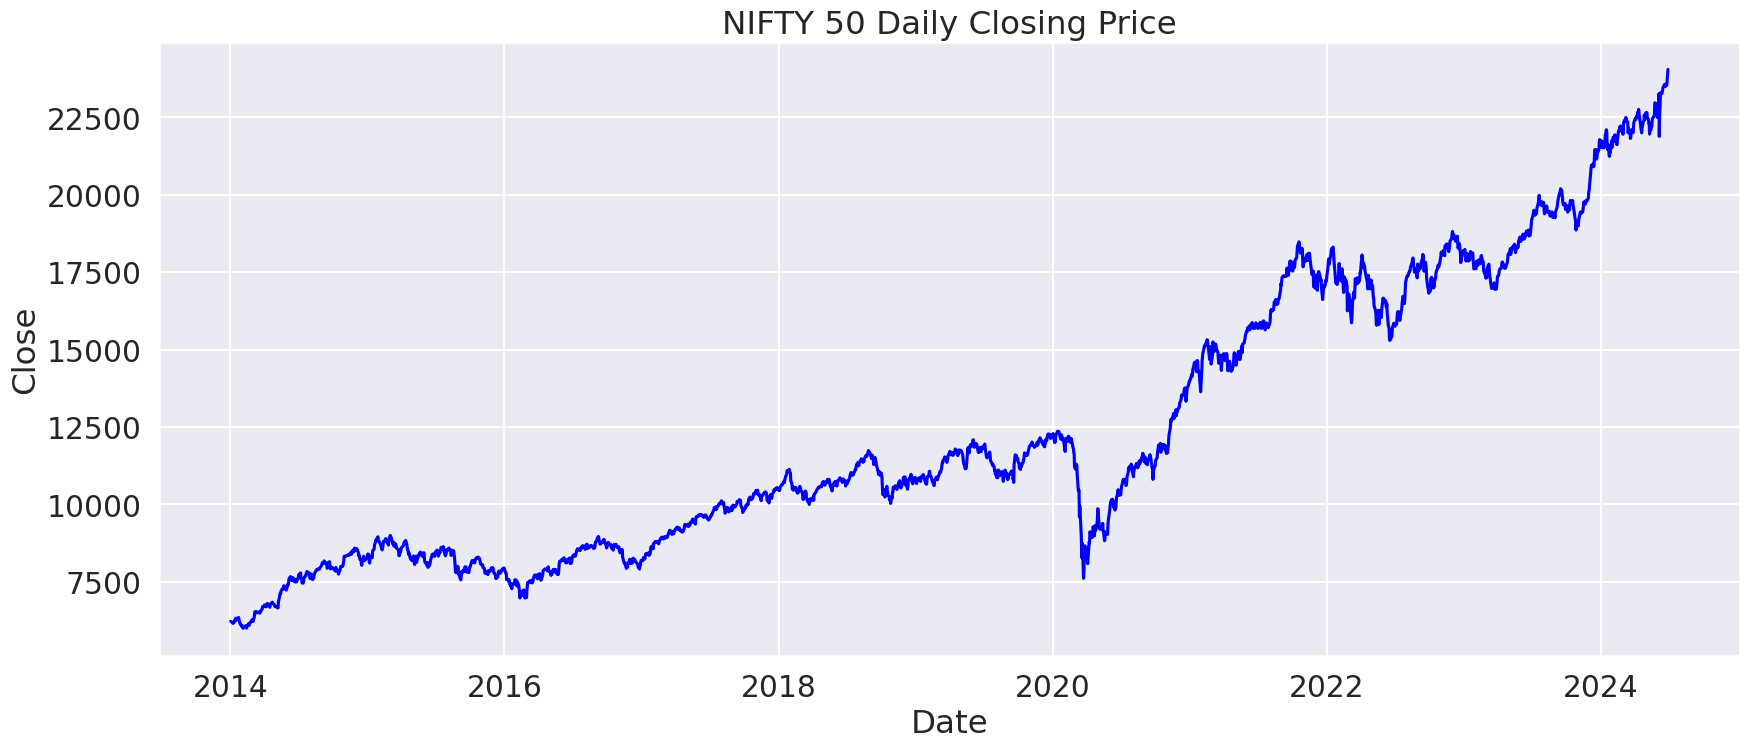

In [10]:
# CHANGE CONTEXT TO poster TO INCREASE FONT SIZES
sns.set_context("talk", font_scale=1.3)

# PLOT OUT BTC-USE'S CLOSING PRICES SINCE 2014
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.lineplot(x=df.index, y=df.Close, color='blue')
    ax.set_title('NIFTY 50 Daily Closing Price')

plt.tight_layout()



In [11]:
df[df['Volume']==0].shape

(25, 7)

### **Types of Volatility and How They are Measured**

(Source: https://www.investopedia.com/terms/v/vix.asp)  

Volatility attempts to measure the **magnitude of price movements that a financial instrument experiences over a certain period of time**. The more dramatic the price swings are in that instrument, the higher the level of volatility, and vice versa.

“Volatility does **not measure the direction** of price changes, merely their dispersion. This is because when calculating standard deviation (or variance), all differences are squared, so that negative and positive differences are combined into one quantity. Two instruments with different volatilities may have the same expected return, but the instrument with higher volatility will have larger swings in values over a given period of time.”
(source: Wikipedia)

Volatility can either be historical or implied; both are usually expressed in percentage terms.

- **Historical Volatility** (HV) or **Realized Volatility** is the actual volatility demonstrated by the underlying over a period of time, such as the past month or year. Realized Volatility is commonly calculated as the standard deviation of price returns,
which is the dollar change in price as a percentage of previous day's price.
- **Implied volatility** (IV), on the other hand, is the level of volatility of the underlying that is implied by the current option price.

In [12]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()

For practicality purposes, it's generally preferable to use the log returns especially in mathematic modeling, because it helps eliminate non-stationary properties of time series data, and makes it more stable:


LOG RETURNS FORMULA:

$r_{t, t+i} = log(P_{t+i} / P_{t})$

There's another advantage to log returns, which is that they're additive across time: $r_{t1, t2} + r_{t2, t3} = r_{t1, t3}$


In [13]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [14]:
df.head()

Open         High          Low        Close  \
Date                                                                            
2014-01-02 00:00:00+05:30  6301.250000  6358.299805  6211.299805  6221.149902   
2014-01-03 00:00:00+05:30  6194.549805  6221.700195  6171.250000  6211.149902   
2014-01-06 00:00:00+05:30  6220.850098  6224.700195  6170.250000  6191.450195   
2014-01-07 00:00:00+05:30  6203.899902  6221.500000  6144.750000  6162.250000   
2014-01-08 00:00:00+05:30  6178.049805  6192.100098  6160.350098  6174.600098   

                           Volume  Dividends  Stock Splits   returns  \
Date                                                                   
2014-01-02 00:00:00+05:30  158100        0.0           0.0       NaN   
2014-01-03 00:00:00+05:30  139000        0.0           0.0 -0.160742   
2014-01-06 00:00:00+05:30  118300        0.0           0.0 -0.317167   
2014-01-07 00:00:00+05:30  138600        0.0           0.0 -0.471621   
2014-01-08 00:00:00+05:30  146900        0.0           0.0  0.200415   

                           log_returns  
Date                                    
2014-01-02 00:00:00+05:30          NaN  
2014-01-03 00:00:00+05:30    -0.001609  
2014-01-06 00:00:00+05:30    -0.003177  
2014-01-07 00:00:00+05:30    -0.004727  
2014-01-08 00:00:00+05:30     0.002002

In [15]:
# DROPPING THE 1ST ROW OF DATA
# BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
df.dropna(inplace=True)

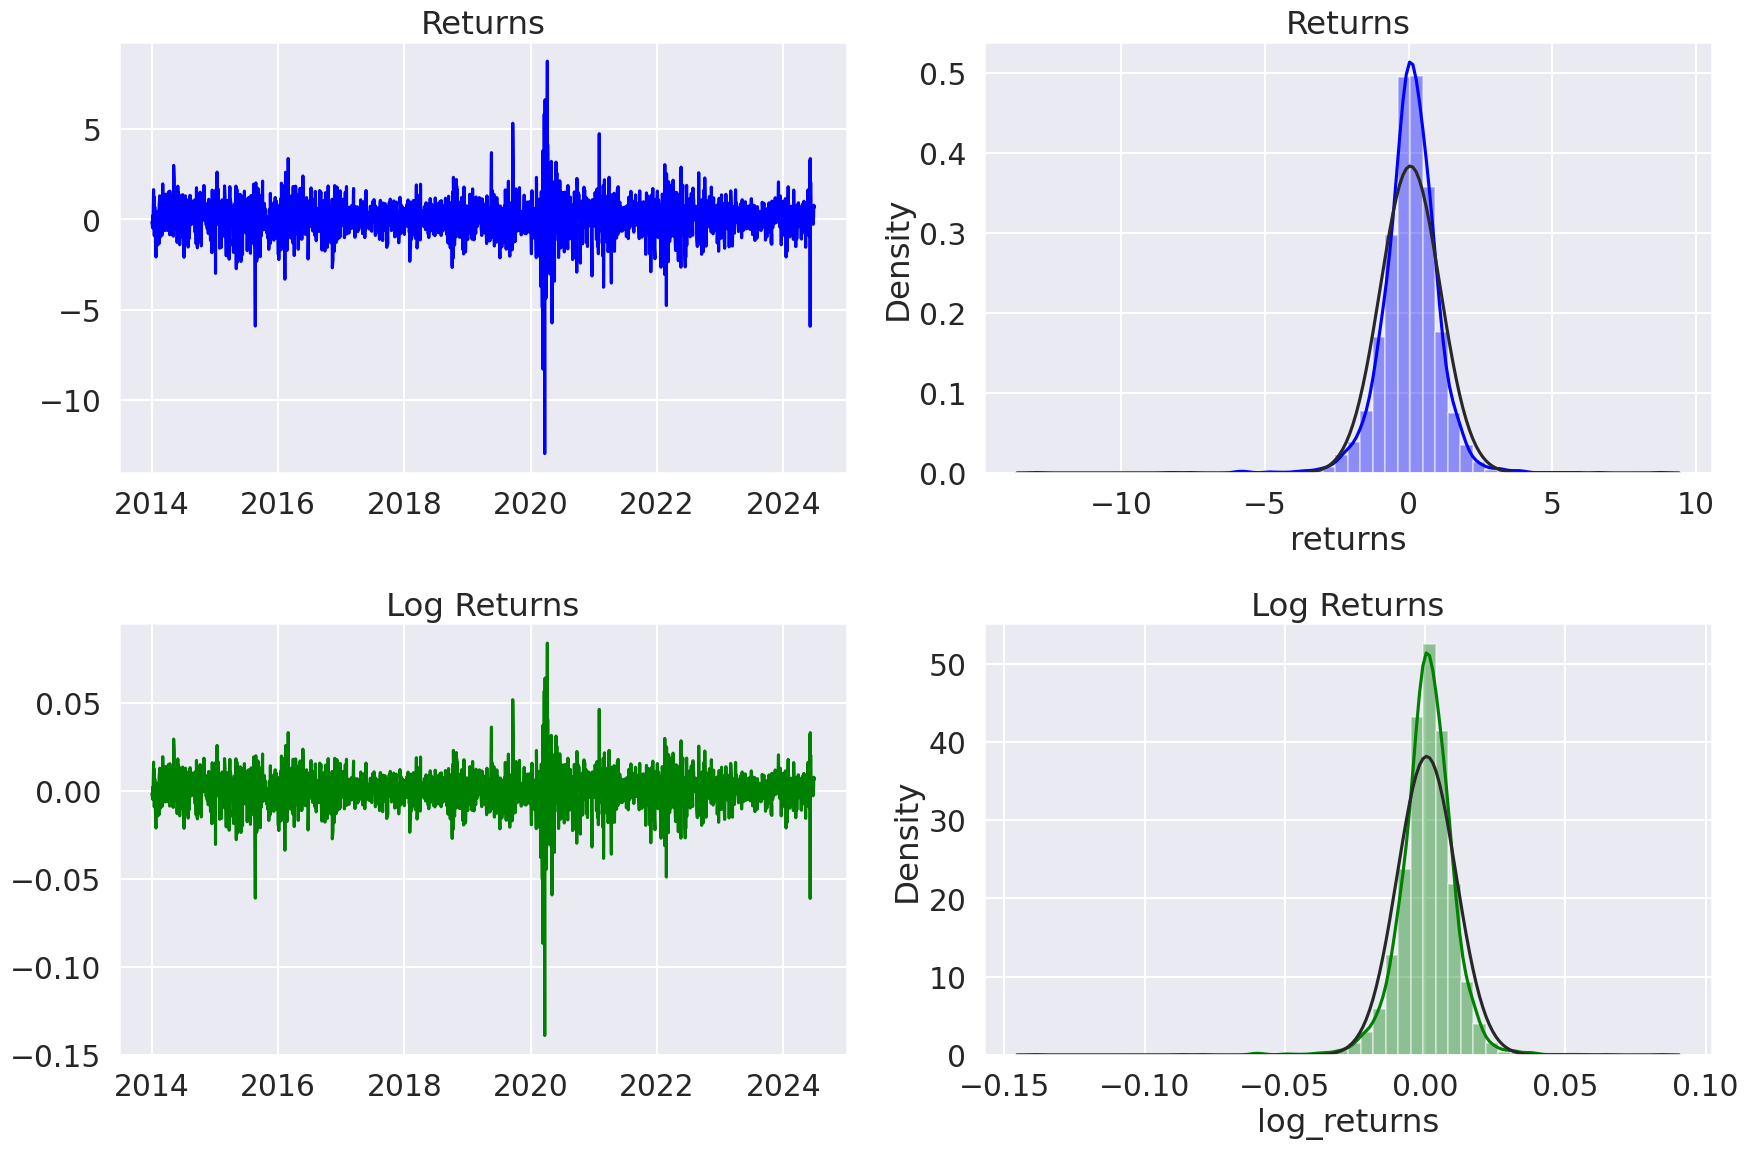

In [16]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(df.returns, color='blue')
    axes[0][0].set_title('Returns')

    sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Returns')

    axes[1][0].plot(df.log_returns, color='green')
    axes[1][0].set_title('Log Returns')

    sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Log Returns')
    plt.tight_layout()
    # plt.savefig(os.path.join(directory_to_img, 'returns_logreturns.png'),
    #             dpi=300, bbox_inches='tight')
    fig.show();

Both Returns & Log Returns show some:
- slight negative skewness
- positive kurtosis (leptokurtic) - higher peak with thicker tails than the standard normal distribution.


In [17]:
df.returns.describe()

count    2571.000000
mean        0.058043
std         1.039568
min       -12.980466
25%        -0.427047
50%         0.083556
75%         0.612840
max         8.763210
Name: returns, dtype: float64

In [18]:
df.log_returns.describe()

count    2571.000000
mean        0.000526
std         0.010459
min        -0.139038
25%        -0.004280
50%         0.000835
75%         0.006110
max         0.084003
Name: log_returns, dtype: float64

(Source: https://www.investopedia.com/articles/investing/102715/computing-historical-volatility-excel.asp)

The standard deviation will be different for log returns computed over longer or shorter intervals. For this specific project, the volatility would be for a certain fixed interval window (`INTERVAL_WINDOW`) is the standard deviation of log returns, or the square root of the sum of squares of log returns:

$\sigma_{interval} = \sqrt{\sum_{t} r_{t-1, t}^2}$

And then to scale the daily volatility by a certain frequency (weekly, monthly, yearly), we can multiply the daily volatility by the square root of that frequency in terms of day divided by the interval minus 1 (`INTERVAL_WINDOW - 1`). For example:

$\sigma_{daily} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{1}{interval-1}}$

$\sigma_{annualized} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{365}{interval-1}}$

$\sigma_{monthly} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{30}{interval-1}}$

$\sigma_{weekly} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{7}{interval-1}}$


In [19]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
# FROM SAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

### Interval Window Selection

For this specific project I'll use an **interval window of 30 days** (equivalent to roughly 1 month of trading for cryptocurrencies). The goal here is to **forecast the average realized volatility of the next `n_future` 7 days** using all previous available datapoint with GARCH models (expanding window forecasting), and using a number of immediate past/historical datapoints (`n_past`) with Neural Networks (sliding window forecasting).


In [20]:
intervals = [7, 30, 60, 180, 365]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df.log_returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)

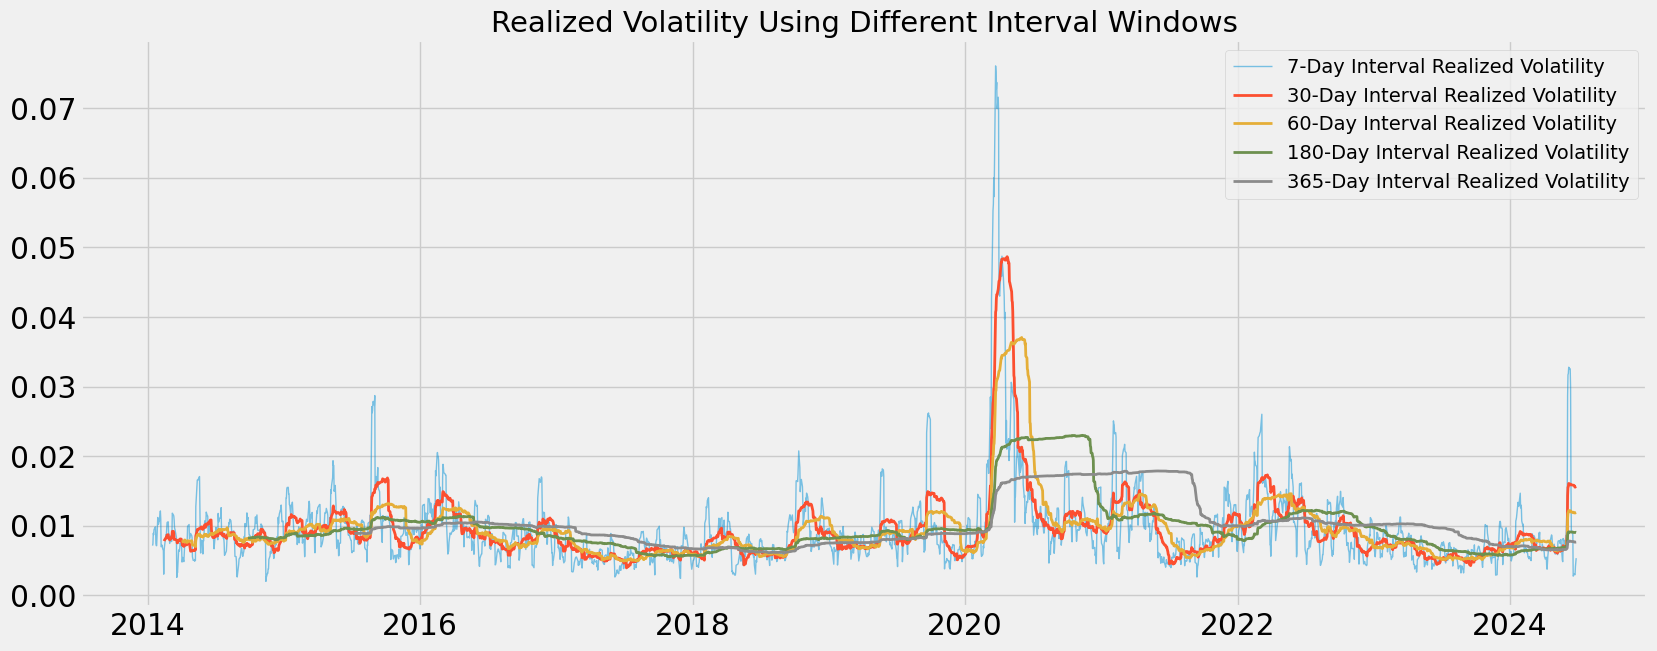

In [21]:
# CHANGING MATPLOTLIB STYLE
plt.style.use(['fivethirtyeight'])

fig, ax = plt.subplots(figsize=(18,7))

for i in intervals:
    if i == 7:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Day Interval Realized Volatility',
            alpha=alpha, lw=lw)

ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=21)

plt.legend(loc='best', prop={'size': 14})
# plt.savefig(os.path.join(directory_to_img, 'diff_intervals.png'),
#             dpi=300, bbox_inches='tight')
plt.show();

The reason I selected 30 days is because 7 days seems too noisy to observe meaningful patterns, while longer intervals seem to smooth the volatility down significantly and tend to revert back to the mean.

Using interval window of 30 days would also help avoid wasting too many datapoints at the beginning of the dataset.

Time-series forecasting models are the models that are capable to predict **future** values based on previously observed values. Target "**future**" data in this case is obtained by **shifting the current volatility backward** by the number of `n_future` lags.

For example, respected to last week's Monday, this week's Monday is the "**future**"; therefore I just need to shift the volatility this week back by 7 days, and use it as the desired "**future**" output for last week's, which I would then use for Neural Networks training and model performance evaluation.

In [22]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [23]:
df.describe()

Open          High           Low         Close        Volume  \
count   2571.000000   2571.000000   2571.000000   2571.000000  2.571000e+03   
mean   12397.385979  12454.781817  12318.825718  12388.824665  3.085660e+05   
std     4451.248826   4467.439912   4428.965567   4450.494498  1.958619e+05   
min     5947.600098   6017.799805   5933.299805   6000.899902  0.000000e+00   
25%     8586.975098   8629.825195   8540.299805   8588.450195  1.780000e+05   
50%    10910.400391  10957.049805  10835.900391  10901.700195  2.474000e+05   
75%    16562.100586  16681.099609  16474.600586  16600.075195  3.704000e+05   
max    23881.550781  24087.449219  23805.400391  24044.500000  1.811000e+06   

       Dividends  Stock Splits      returns  log_returns  vol_current  \
count     2571.0        2571.0  2571.000000  2571.000000  2542.000000   
mean         0.0           0.0     0.058043     0.000526     0.009308   
std          0.0           0.0     1.039568     0.010459     0.005146   
min          0.0           0.0   -12.980466    -0.139038     0.003931   
25%          0.0           0.0    -0.427047    -0.004280     0.006624   
50%          0.0           0.0     0.083556     0.000835     0.008165   
75%          0.0           0.0     0.612840     0.006110     0.010398   
max          0.0           0.0     8.763210     0.084003     0.048656   

        vol_future  
count  2535.000000  
mean      0.009311  
std       0.005153  
min       0.003931  
25%       0.006620  
50%       0.008163  
75%       0.010401  
max       0.048656

The 2 columns `Dividends` and `Stock Splits` don't store any information, all rows are `0.0`, so I'll remove them.

In [24]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

In [25]:
df.describe()

Open          High           Low         Close        Volume  \
count   2571.000000   2571.000000   2571.000000   2571.000000  2.571000e+03   
mean   12397.385979  12454.781817  12318.825718  12388.824665  3.085660e+05   
std     4451.248826   4467.439912   4428.965567   4450.494498  1.958619e+05   
min     5947.600098   6017.799805   5933.299805   6000.899902  0.000000e+00   
25%     8586.975098   8629.825195   8540.299805   8588.450195  1.780000e+05   
50%    10910.400391  10957.049805  10835.900391  10901.700195  2.474000e+05   
75%    16562.100586  16681.099609  16474.600586  16600.075195  3.704000e+05   
max    23881.550781  24087.449219  23805.400391  24044.500000  1.811000e+06   

           returns  log_returns  vol_current   vol_future  
count  2571.000000  2571.000000  2542.000000  2535.000000  
mean      0.058043     0.000526     0.009308     0.009311  
std       1.039568     0.010459     0.005146     0.005153  
min     -12.980466    -0.139038     0.003931     0.003931  
25%      -0.427047    -0.004280     0.006624     0.006620  
50%       0.083556     0.000835     0.008165     0.008163  
75%       0.612840     0.006110     0.010398     0.010401  
max       8.763210     0.084003     0.048656     0.048656

Since I am currently using an `INTERVAL_WINDOW` of 30 and a horizon `n_future` of  7, the volatilty of first 30 values as well as the last 7 values of the dataframe would be `NaN`, and therefore need to be dropped from the dataset.

In [26]:
# DROPPING ALL NaN VALUES
df.dropna(inplace=True)

## **Exploratory Data Analysis**

First I would just plot out my desired target outputs `vol_future` with respect to the current volatility `vol_current`. The first plot shows all the datapoints I have available that covers 7 years, but then the second plot is only zooming in the most recent 365 days.

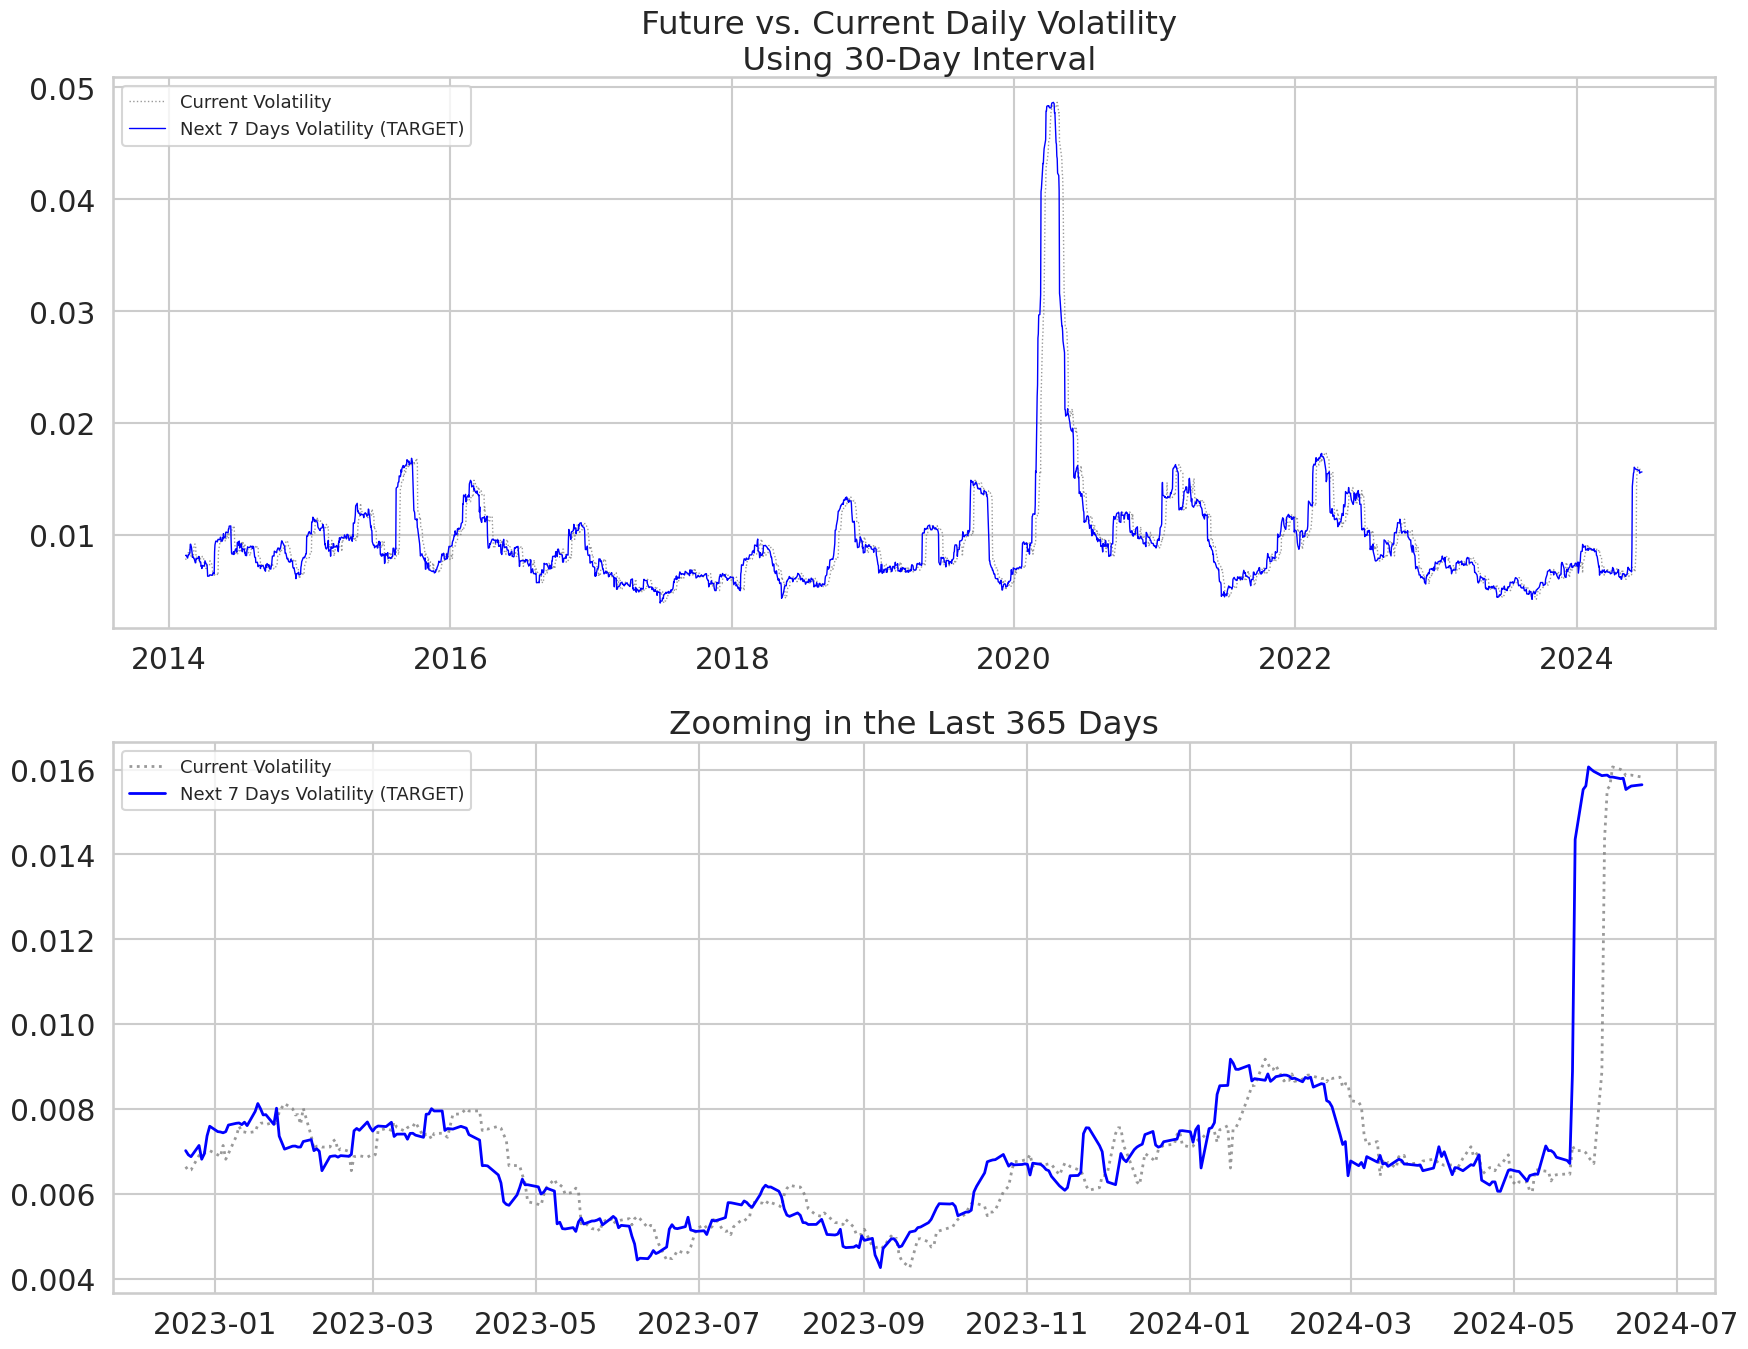

In [27]:
n_zoom = 365
sns.set_context("talk", font_scale=1.3)
# plt.style.use(['seaborn'])

# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, alpha=.8, lw=1, color='gray', ls=':',
            label='Current Volatility')
    ax1.plot(df.vol_future, lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax2.plot(df.vol_current[-n_zoom:], alpha=.8, lw=2, color='gray', ls=':',
            label='Current Volatility')
    ax2.plot(df.vol_future[-n_zoom:], lw=2, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax1.title.set_text(f'Future vs. Current Daily Volatility \n Using {INTERVAL_WINDOW}-Day Interval')
    ax2.title.set_text(f'Zooming in the Last {n_zoom} Days')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.tight_layout()
    # plt.savefig(os.path.join(directory_to_img, 'daily_vol.jpg'),
    #             dpi=300, bbox_inches='tight')
    plt.show();

In the plot above, the **blue line** indicates the **target future** value that I ultimately try to match up to.

And the dotted **gray line** represents the **current volatility** in real-time.

This is a visualization of how current volatility is shifted backward to become future values, which I want to eventually aim for.

### **Daily Volatility Grouped by Month**

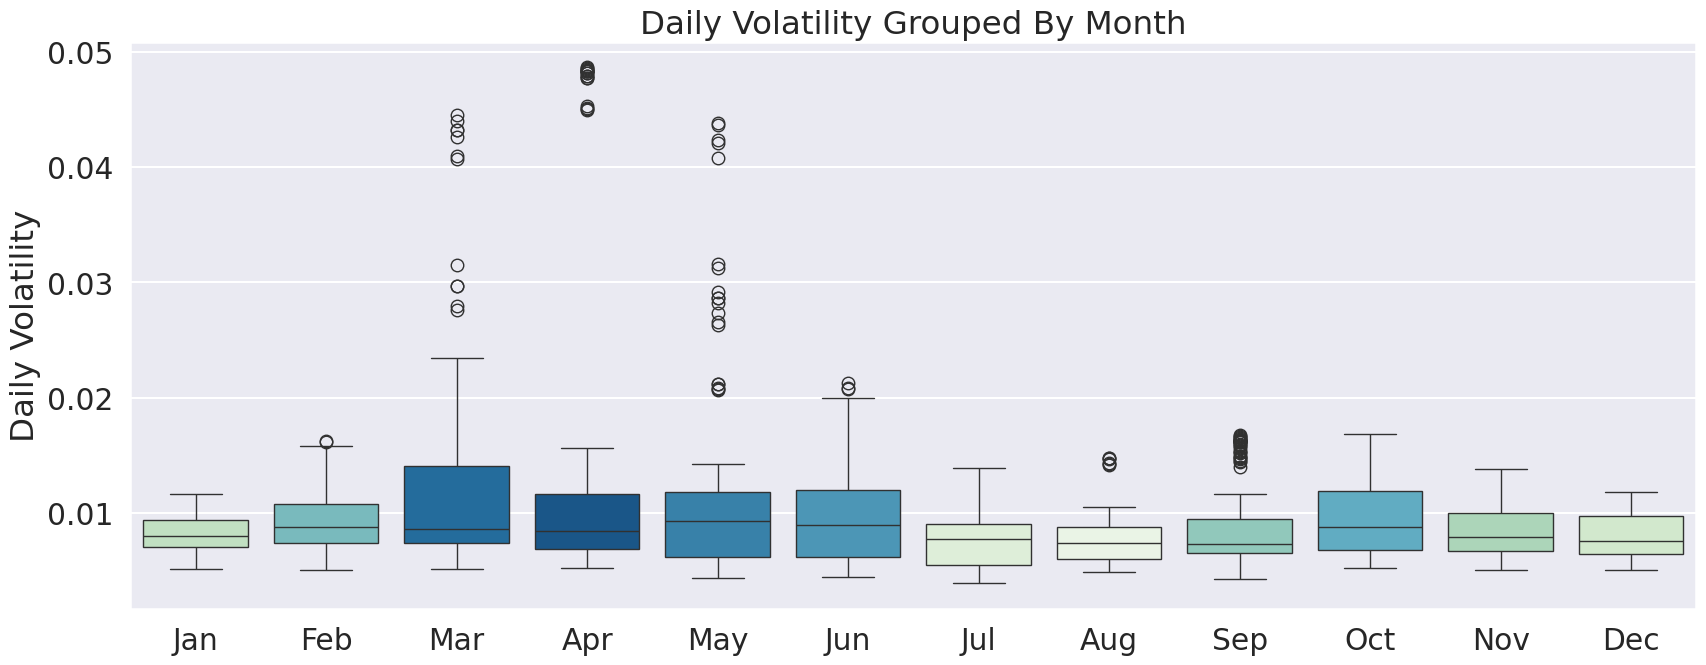

In [28]:
# PRESORT MONTHS IN CHRONOLOGICAL ORDER
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun',
                  'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']

# GROUP vol_current BY MONTH AND TAKE THE MEAN
data = df.groupby(by=[df.index.month_name()]).vol_current.mean()

# ABBREVIATE MONTH NAME
data.index = [x[:3] for x in data.index]

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort().reindex(ordered_months)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))

    sns.boxplot(x=[x[:3] for x in df.index.month_name()],
                y=df.vol_current,
                palette=np.array(pal)[rank],
                order=ordered_months)
    ax.set(xlabel='',
           ylabel='Daily Volatility',
           title='Daily Volatility Grouped By Month')
    # plt.savefig(os.path.join(directory_to_img, "vol_by_month.png"),
    #             dpi=300, bbox_inches='tight')
    plt.show()

In [29]:
df.vol_current.sort_values(ascending=False)[:50]

Date
2020-04-23 00:00:00+05:30    0.048656
2020-04-22 00:00:00+05:30    0.048590
2020-04-24 00:00:00+05:30    0.048538
2020-04-21 00:00:00+05:30    0.048416
2020-04-13 00:00:00+05:30    0.048364
2020-04-16 00:00:00+05:30    0.048363
2020-04-15 00:00:00+05:30    0.048348
2020-04-09 00:00:00+05:30    0.048306
2020-04-17 00:00:00+05:30    0.048174
2020-04-20 00:00:00+05:30    0.048161
2020-04-08 00:00:00+05:30    0.047872
2020-04-07 00:00:00+05:30    0.047868
2020-04-28 00:00:00+05:30    0.047744
2020-04-27 00:00:00+05:30    0.047704
2020-04-03 00:00:00+05:30    0.045301
2020-04-01 00:00:00+05:30    0.045144
2020-04-29 00:00:00+05:30    0.045077
2020-04-30 00:00:00+05:30    0.044925
2020-03-31 00:00:00+05:30    0.044515
2020-03-30 00:00:00+05:30    0.043976
2020-05-04 00:00:00+05:30    0.043849
2020-05-05 00:00:00+05:30    0.043631
2020-03-26 00:00:00+05:30    0.043207
2020-03-27 00:00:00+05:30    0.043185
2020-03-25 00:00:00+05:30    0.042637
2020-05-06 00:00:00+05:30    0.042340
2020-05

### **Daily Volatility Grouped by Year**

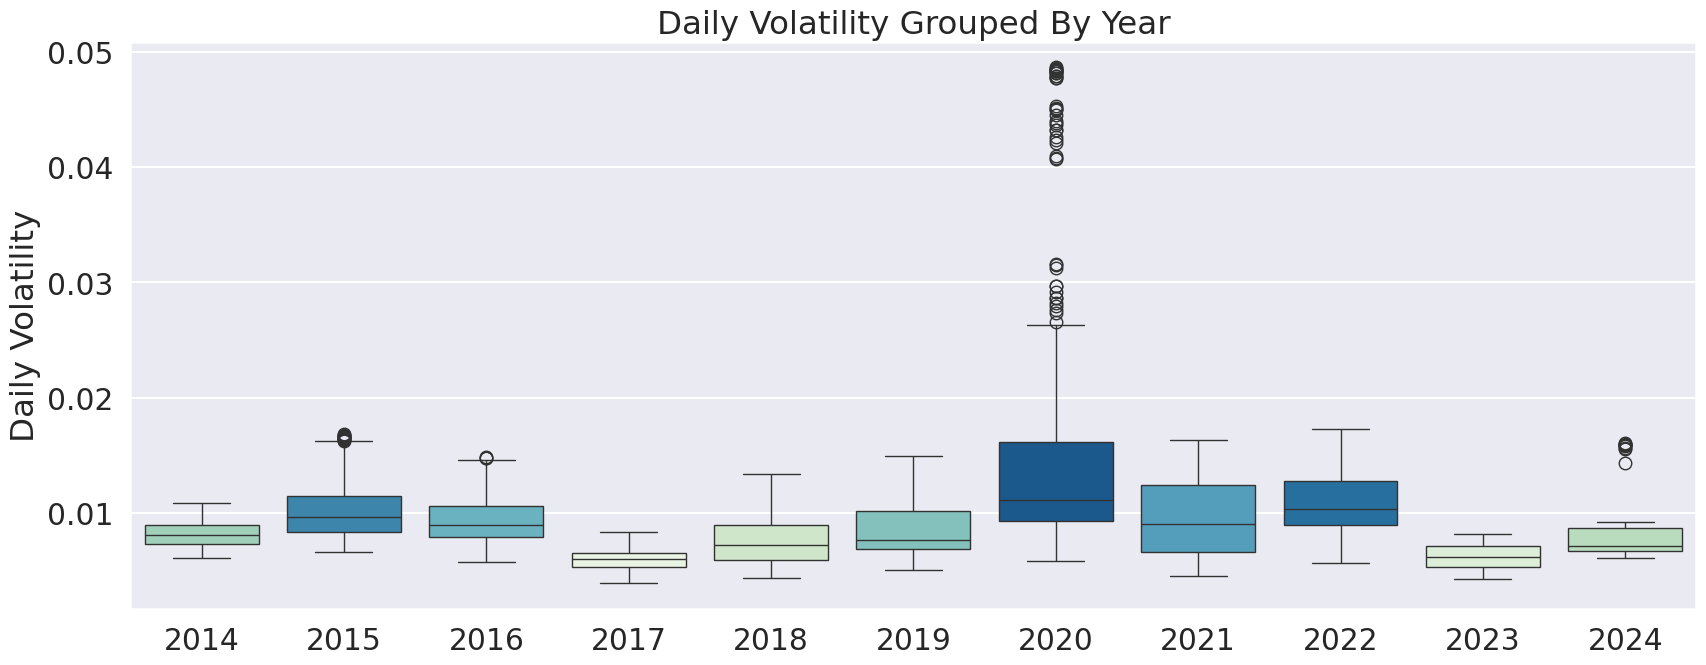

In [30]:
# GROUP vol_current BY YEAR AND TAKE THE MEAN
data = df.groupby(by=[df.index.year]).vol_current.mean()

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort()

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))

    sns.boxplot(x=df.index.year,
                y=df.vol_current,
                palette=np.array(pal)[rank])
    ax.set(xlabel='',
           ylabel='Daily Volatility',
           title='Daily Volatility Grouped By Year')
    # plt.savefig(os.path.join(directory_to_img, "vol_by_year.png"),
    #             dpi=300, bbox_inches='tight')
    plt.show()

### **Daily Volatility Distribution**

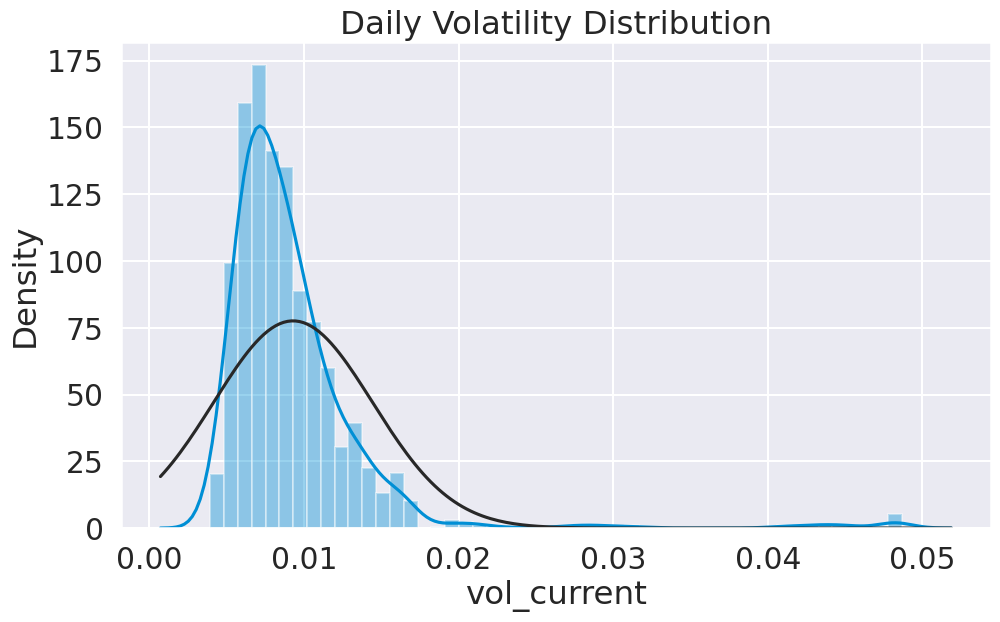

In [31]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(df.vol_current, norm_hist=True, fit=stats.norm,
                bins=50, ax=ax)
    plt.title('Daily Volatility Distribution')
    # plt.savefig(os.path.join(directory_to_img, "vol_dist.png"),
    #             dpi=300, bbox_inches='tight')
    plt.show();

### **Returns/Log Returns Stationarity Checking**



In [32]:
from statsmodels.tsa.stattools import adfuller

In [33]:
# LOG RETURNS
adfuller_results = adfuller(df.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -13.845609986688977
p-value: 7.158951550106256e-26
Critical Values:
1%: -3.4329
5%: -2.8627
10%: -2.5674


In [34]:
# RETURNS
adfuller_results = adfuller(df.returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -13.972824248483201
p-value: 4.314354190514912e-26
Critical Values:
1%: -3.4329
5%: -2.8627
10%: -2.5674


Using a significant level alpha of 0.05, `p-value` for both Returns and Log Returns are significantly smaller than alpha, which means there's enough evidence to reject the Null Hypothesis.

--> Returns and Log returns are both not dependent on time/trend

## **Train-Validation-Test Splits**

I would split the dataset into 3 parts as follows:
- the most recent 30 usable datapoints would be used for **Final Model Testing - approx. 1.2%**
- 1 full year (365 days) for **Validation and Model Tuning during training - approx. 14.7%**
- and the remaining for **Training - approx. 84.1%**

In [35]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 30
val_size = 365

# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [36]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2014-02-13 00:00:00+05:30 	to: 2022-11-07 00:00:00+05:30 	2140 days
VALIDATION 	From: 2022-11-09 00:00:00+05:30 	to: 2024-05-03 00:00:00+05:30 	365 days
TEST 		From: 2024-05-06 00:00:00+05:30 	to: 2024-06-18 00:00:00+05:30 	30 days


The target here would be `vol_future` which represents the daily realized volatility of the next `n_future` days from today (average daily volatility from `t + n_future - INTERVAL_WINDOW` to time step `t + n_future`).

For example, using an `n_future` value of 7 and an `INTERVAL_WINDOW` of 30, the value that I want to predict at time step `t` would be the average daily realized volatility from time step `t-22` to time step `t+7`.

In [37]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [38]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS
# (this would be the input for baseline, random walk, and NN models)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [39]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [40]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

In [41]:
y_train.describe()

count    2140.000000
mean        0.009743
std         0.005424
min         0.003931
25%         0.006887
50%         0.008753
75%         0.010764
max         0.048656
Name: vol_future, dtype: float64

In [42]:
x_train.describe()

count    2140.000000
mean        0.009741
std         0.005425
min         0.003931
25%         0.006887
50%         0.008743
75%         0.010764
max         0.048656
Name: vol_current, dtype: float64

## **Data Preprocessing**

### 1. Feature Normalization

As I am going to build various types of models based on different algorithms using different types of inputs, it would be better to normalize the volatilities to standardize the predictions generated by different models. After experimenting with different Scalers, I decided to use `MinMaxScaler` as it yielded best results overall.

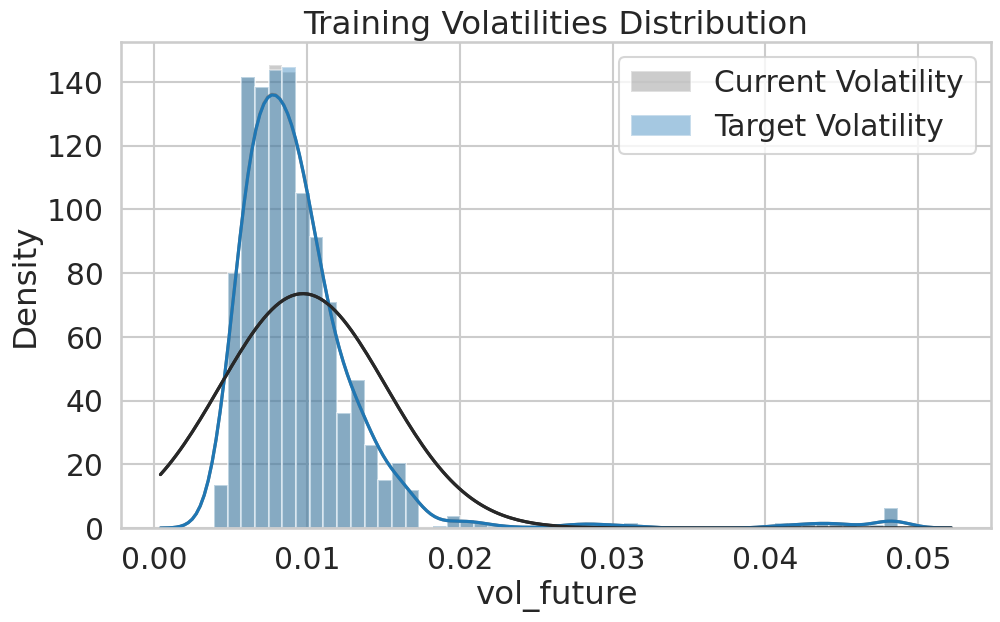

In [43]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train, norm_hist=True, fit=stats.norm,
                 color='gray',
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train, norm_hist=True, fit=stats.norm,
                 color='tab:blue',
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution')
    plt.legend()
    # plt.savefig(os.path.join(directory_to_img, "vol_dist.png"),
    #             dpi=300, bbox_inches='tight')
    plt.show();

In [44]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [45]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [46]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

In [47]:
x_train.head(10)

Date
2014-02-13 00:00:00+05:30    0.007791
2014-02-14 00:00:00+05:30    0.007920
2014-02-18 00:00:00+05:30    0.008255
2014-02-19 00:00:00+05:30    0.008245
2014-02-20 00:00:00+05:30    0.008444
2014-02-21 00:00:00+05:30    0.008662
2014-02-24 00:00:00+05:30    0.008711
2014-02-25 00:00:00+05:30    0.008180
2014-02-26 00:00:00+05:30    0.008210
2014-02-28 00:00:00+05:30    0.007951
Name: vol_current, dtype: float64

In [48]:
y_train.head(10)

Date
2014-02-13 00:00:00+05:30    0.008180
2014-02-14 00:00:00+05:30    0.008210
2014-02-18 00:00:00+05:30    0.007951
2014-02-19 00:00:00+05:30    0.008120
2014-02-20 00:00:00+05:30    0.008260
2014-02-21 00:00:00+05:30    0.008215
2014-02-24 00:00:00+05:30    0.008478
2014-02-25 00:00:00+05:30    0.009183
2014-02-26 00:00:00+05:30    0.009186
2014-02-28 00:00:00+05:30    0.008917
Name: vol_future, dtype: float64

In [49]:
x_train_scaled.head(10)

Date
2014-02-13 00:00:00+05:30    0.086297
2014-02-14 00:00:00+05:30    0.089189
2014-02-18 00:00:00+05:30    0.096684
2014-02-19 00:00:00+05:30    0.096455
2014-02-20 00:00:00+05:30    0.100902
2014-02-21 00:00:00+05:30    0.105779
2014-02-24 00:00:00+05:30    0.106863
2014-02-25 00:00:00+05:30    0.094995
2014-02-26 00:00:00+05:30    0.095674
2014-02-28 00:00:00+05:30    0.089891
dtype: float64

In [50]:
y_train_scaled.head(10)

Date
2014-02-13 00:00:00+05:30    0.094995
2014-02-14 00:00:00+05:30    0.095674
2014-02-18 00:00:00+05:30    0.089891
2014-02-19 00:00:00+05:30    0.093670
2014-02-20 00:00:00+05:30    0.096801
2014-02-21 00:00:00+05:30    0.095786
2014-02-24 00:00:00+05:30    0.101666
2014-02-25 00:00:00+05:30    0.117433
2014-02-26 00:00:00+05:30    0.117497
2014-02-28 00:00:00+05:30    0.111473
dtype: float64

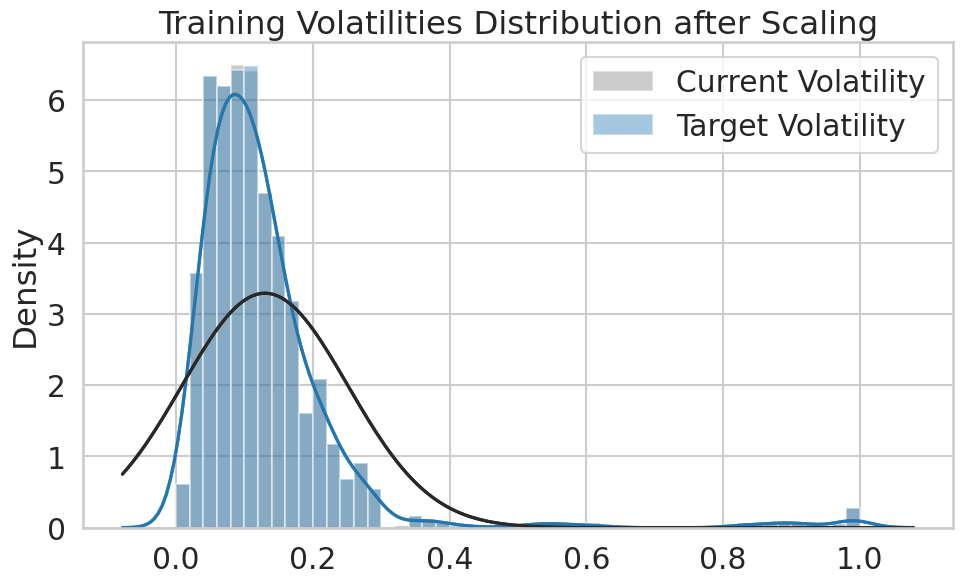

In [51]:
# PLOTTING VOLATILITIES AFTER SCALING
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm,
                 color='gray',
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue',
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()
    # plt.savefig(os.path.join(directory_to_img, "vol_dist.png"),
    #             dpi=300, bbox_inches='tight')
    plt.show();

### 2. Train-Validation-Test Visualization

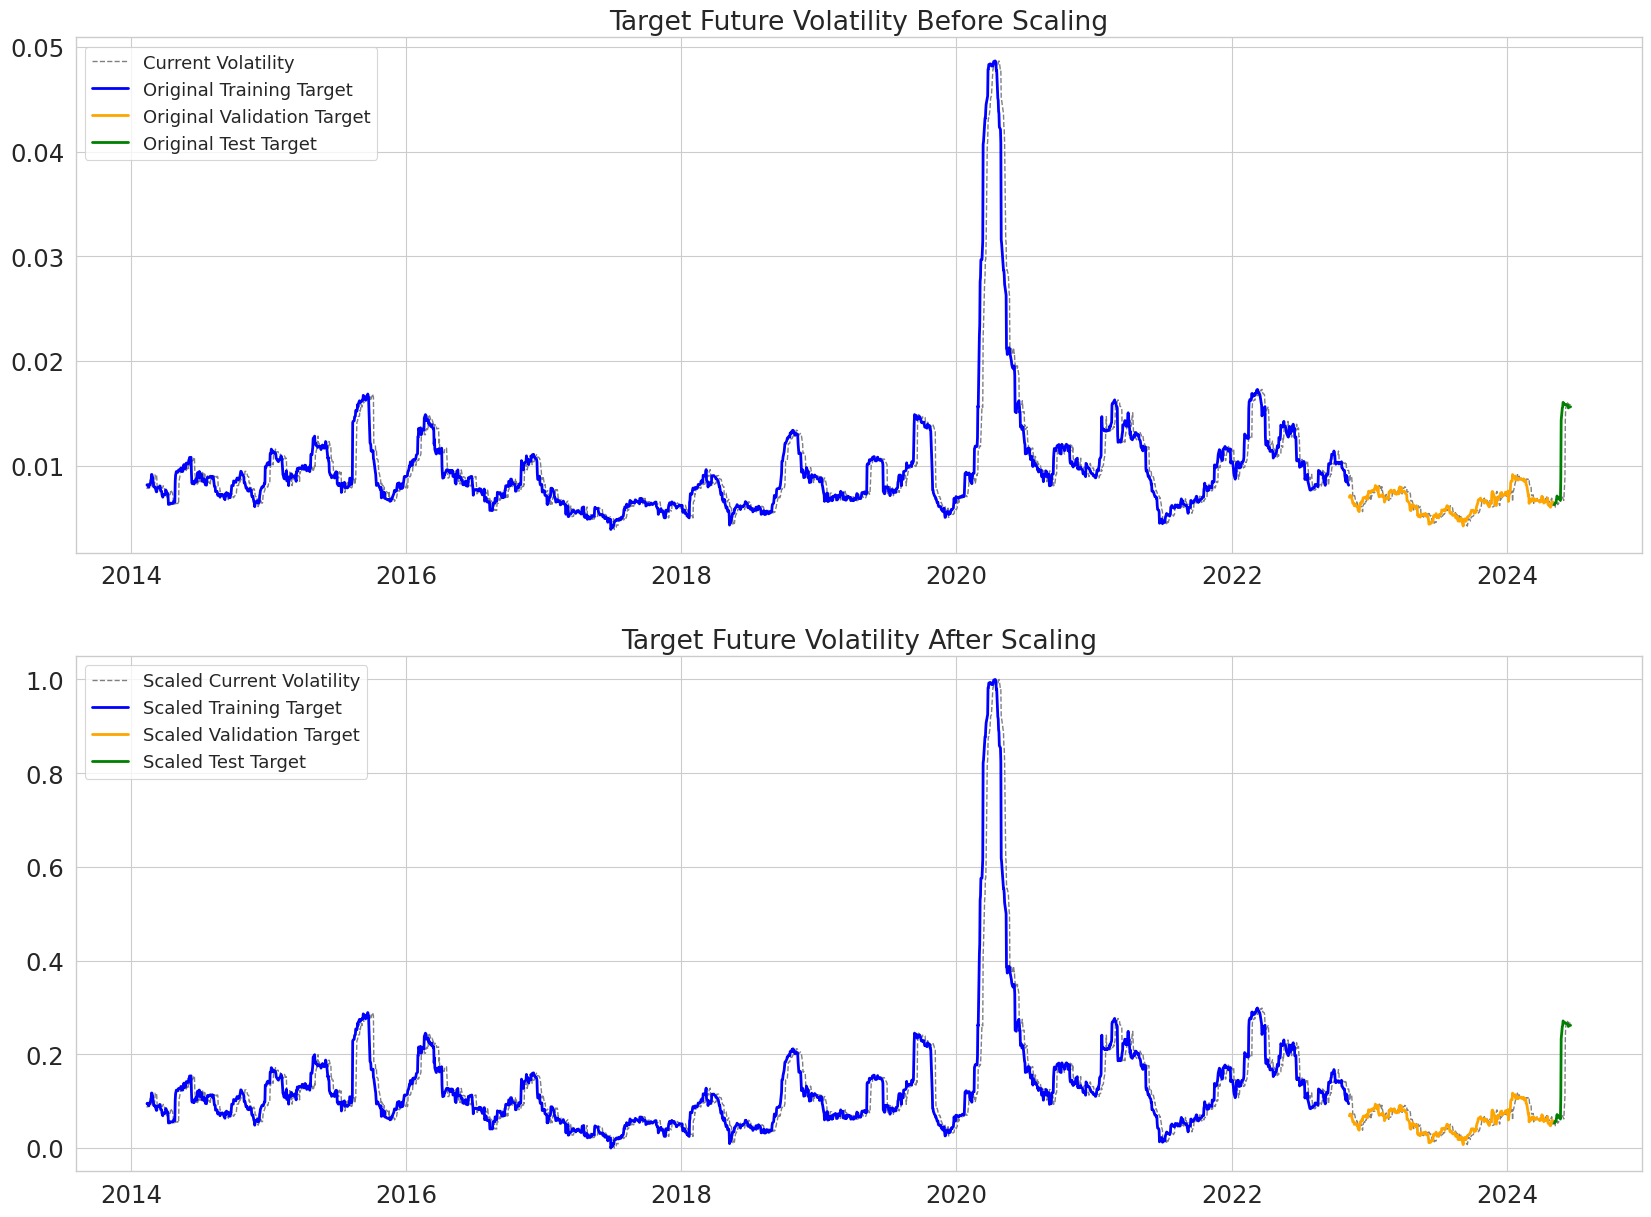

In [52]:
sns.set_context("paper", font_scale=2)

# VISUALIZE TRAIN/VALIDATION/TEST vol_future BEFORE & AFTER TRAINING
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, lw=1, color='gray', ls='--',
                label='Current Volatility')
    ax1.plot(y_train, color='blue', label='Original Training Target', lw=2)
    ax1.plot(y_val, color='orange', label='Original Validation Target', lw=2)
    ax1.plot(y_test, color='green', label='Original Test Target', lw=2)

    ax1.title.set_text('Target Future Volatility Before Scaling')

    ax2.plot(transform_volatility_to_scaler(scaler_vol, df.vol_current),
                lw=1, color='gray', ls='--',
                label='Scaled Current Volatility')
    ax2.plot(y_train_scaled, color='blue', label='Scaled Training Target', lw=2)
    ax2.plot(y_val_scaled, color='orange', label='Scaled Validation Target', lw=2)
    ax2.plot(y_test_scaled, color='green', label='Scaled Test Target', lw=2)

    ax2.title.set_text('Target Future Volatility After Scaling')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    # plt.savefig(os.path.join(directory_to_img, 'train_val_test_org_scled.png'),
    #             dpi=300, bbox_inches='tight')
    plt.show();

One of the most obvious difference between the 2 plots is the y-axis. After scaling, volatilities fall in the range of [0,1] instead of [0, 0.12] as before.

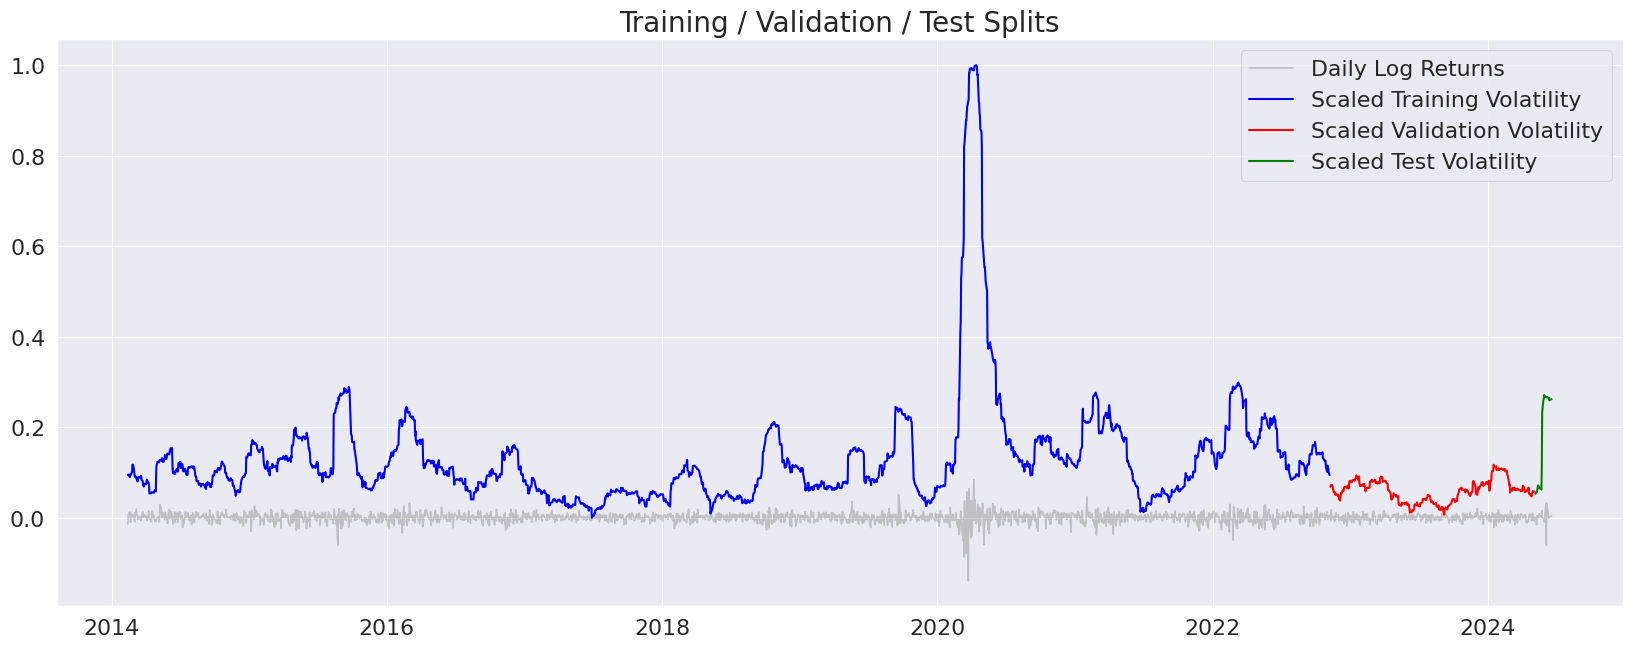

In [53]:
sns.set_context("paper", font_scale=1.8)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,7))

    plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

    plt.plot(y_train_scaled, color='blue',
             label='Scaled Training Volatility', lw=1.5)
    plt.plot(y_val_scaled, color='red',
             label='Scaled Validation Volatility', lw=1.5)
    plt.plot(y_test_scaled, color='green',
             label='Scaled Test Volatility', lw=1.5)

    plt.plot()
    plt.title('Training / Validation / Test Splits', fontsize=20)
    plt.legend(frameon=True)
    # plt.savefig(os.path.join(directory_to_img, 'train_val_test.png'),
    #             dpi=300, bbox_inches='tight')
    plt.show();

# MODELING

## 1. Performance Metrics

Usually with financial time series, if we just shift through the historic data trying different methods, parameters and timescales, it's almost certain to find to some strategy with in-sample profitability at some point. However the whole purpose of "forecasting" is to predict the future based on currently available information, and a model that performs best on training data might not be the best when it comes to out-of-sample generalization (or **overfitting**). Avoiding/Minimizing overfitting is even more important in the constantly evolving financial markets where the stake is high.

The 2 main metrics I'd be using are **RMSPE (Root Mean Squared Percentage Error)** and **RMSE (Root Mean Square Errors)** with RMSPE prioritized. Timescaling is very important in the calculation of volatility due to the level of freedom in frequency/interval window selection. Therefore I think RMSPE would help capture degree of errors compared to desired target values better than other metrics. Also RMSPE would punish large errors more than regular MAPE (Mean Absolute Percentage Error), which is what I want to do here.

RMSE and RMSPE would be tracked across different models' performance on validation set forecasting to indicate their abilities to generalize on out-of-sample data.

In [54]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [55]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [56]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [57]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name,
                                       RMSPE(y_true, y_pred),
                                       RMSE(y_true, y_pred)]
    return perf_df

In [58]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")

        plt.plot(y_true, color='blue', lw=2,
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')

        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

## 2. Baseline Models

### 2.1. Mean Baseline

One of the essential characteristics of Volatility is it's **mean-revert** over the long term. Therfore my first baseline model his would be a very simple one that only outputs the average current realized volatility of the whole training set as predictions everything.

In [59]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_train_vol = x_train_scaled.mean()
mean_train_vol

0.12991029804491136

In [60]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

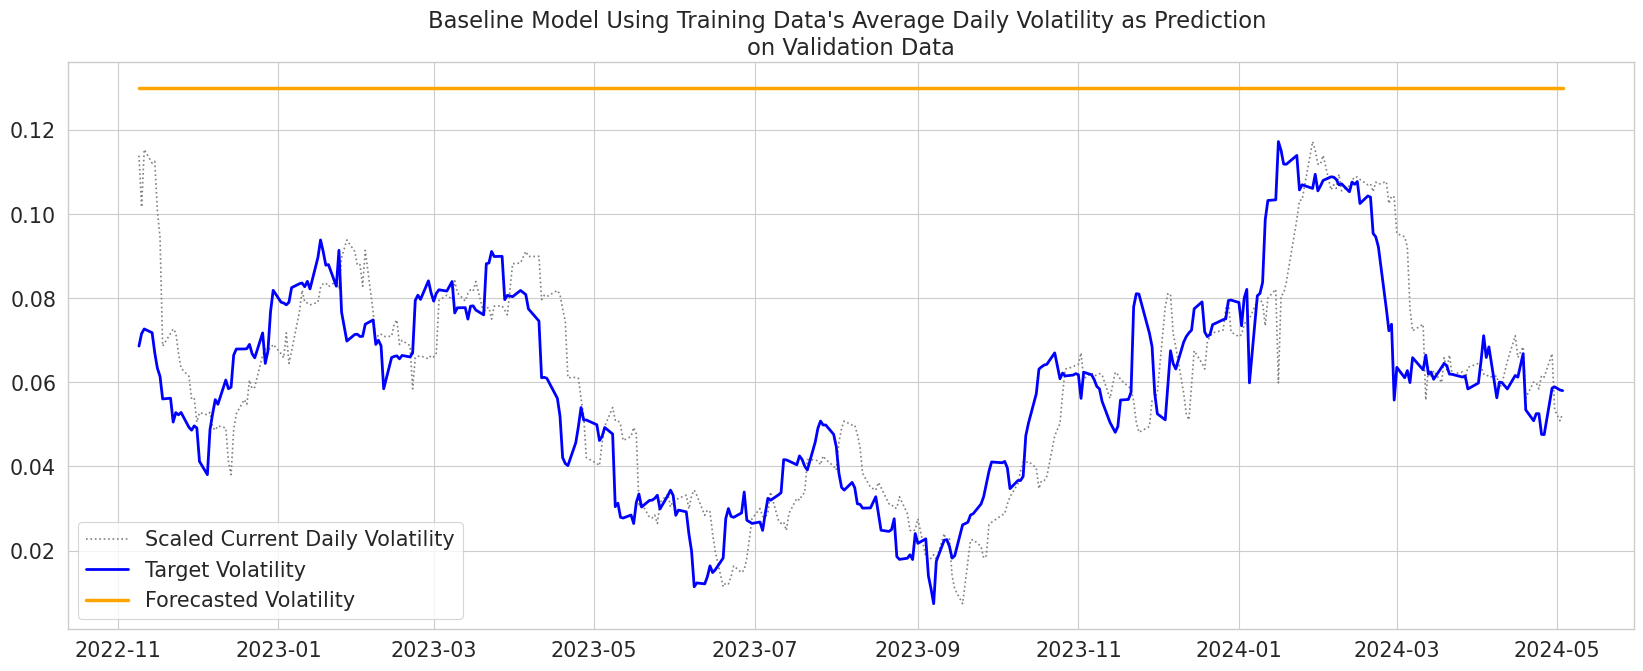

In [61]:
viz_model(y_val_scaled, baseline_preds,
          f"Baseline Model Using Training Data's Average Daily Volatility as Prediction")
# plt.savefig(os.path.join(directory_to_img, 'baseline.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [62]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

Model  Validation RMSPE  Validation RMSE
0  Mean Baseline          2.642807         0.075018

## 3. GARCH Models

(Reference: http://users.metu.edu.tr/ozancan/ARCHGARCHTutorial.html)

GARCH stands for **Generalized Autoregressive Conditional Heteroskedasticity**, which is an extension of the ARCH model (Autoregressive Conditional Heteroskedasticity).

GARCH includes lag variance terms with lag residual errors from a mean process, and is the traditional econometric approach to volatility prediction of financial time series.

Mathematically, GARCH can be represented as follows:

\begin{align*}
\sigma_{t}^2 = \omega + \sum_{i}^{q}\alpha_{i}\epsilon_{t-i}^2 + \sum_{1}^{p}\beta_{i}\sigma_{t-i}^2
\end{align*}

in which $\sigma_{t}^2$ is variance at time step `t` and $\epsilon_{t-i}^2$ is the model residuals at time step `t-1`

GARCH(1,1) only contains first-order lagged terms and the mathematic equation for it is:

\begin{align*}
\sigma^2_t = \omega + \alpha\epsilon^{2}_{(t-1)} + \beta\sigma^{2}_{(t-1)}
\end{align*}

where $\alpha$, $\beta$ and $\omega$ sum up to 1, and $\omega$ is the long term variance.


(Reference: **Positional Option Trading** - Euan Sinclair)

GARCH is generally regarded as an insightful improvement on naively assuming future volatility will be like the past, but also considered widely overrated as predictor by some experts in the field of volatility. GARCH models capture the essential characteristics of volatility: volatility tomorrow will be close to what it is today (**clustering**), and volatility in the long term will probably **mean revert** (meaning it'd be close to whatever the historical long-term average has been).

### 3.1. Basic GARCH

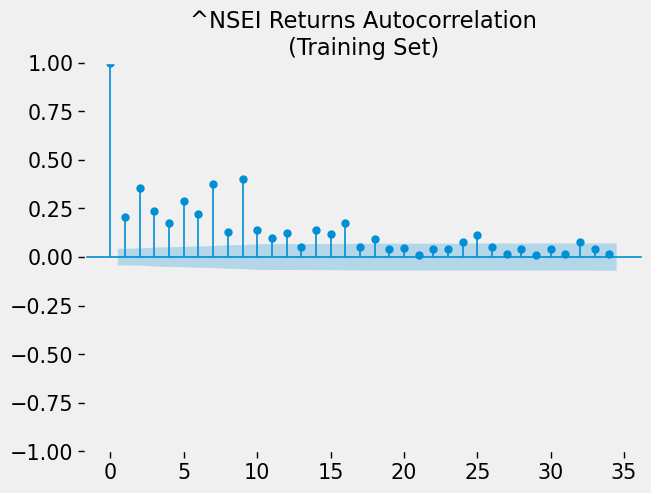

In [63]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2,
          title=f'{tckr.upper()} Returns Autocorrelation\n(Training Set)');

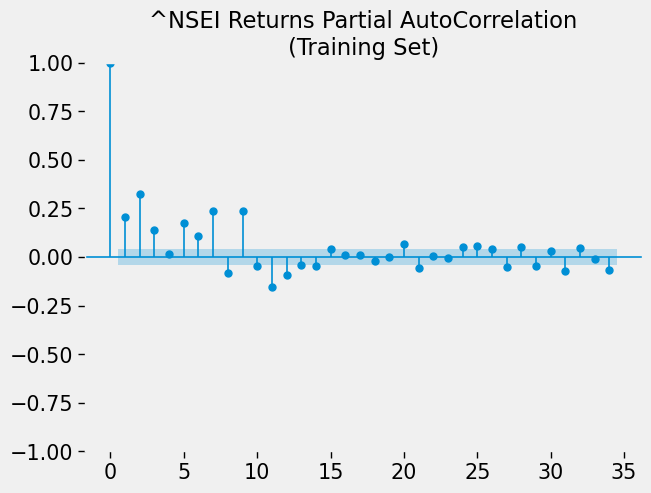

In [64]:
# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2,
          title=f'{tckr.upper()} Returns Partial AutoCorrelation\n(Training Set)');

In [65]:
from arch import arch_model

In [66]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gm_1 = arch_model(r_train, p=7, q=7)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2857.89
Distribution:                  Normal   AIC:                           5747.78
Method:            Maximum Likelihood   BIC:                           5838.48
                                        No. Observations:                 2140
Date:                Tue, Jul 02 2024   Df Residuals:                     2139
Time:                        10:08:08   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0887  1.955e-02      4.539  5.658e-06 [5.042e-

Using a significance level of 0.05, none of the coefficients seems to be statistically significant (because their p-values `P > |t|` are all greater than 0.05). Therefore, I'll reduce the values of `p` and `q` to 1 to see if that helps.

In [67]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2862.76
Distribution:                  Normal   AIC:                           5733.51
Method:            Maximum Likelihood   BIC:                           5756.19
                                        No. Observations:                 2140
Date:                Tue, Jul 02 2024   Df Residuals:                     2139
Time:                        10:08:09   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0903  1.945e-02      4.641  3.463e-06 [5.216e-

All coefficients look statistically significant now.

After being fitted to the training data (percent returns), the GARCH model forecast contains an estimated conditional volatility attribute for the training portion of the time series. I am going to fit - transform the scaler to the training data's conditional volatility arrays, and then plot it out to compare it with the realized volatility calculated above (also scaled) `x_train_scaled`.

In [68]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [69]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [70]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

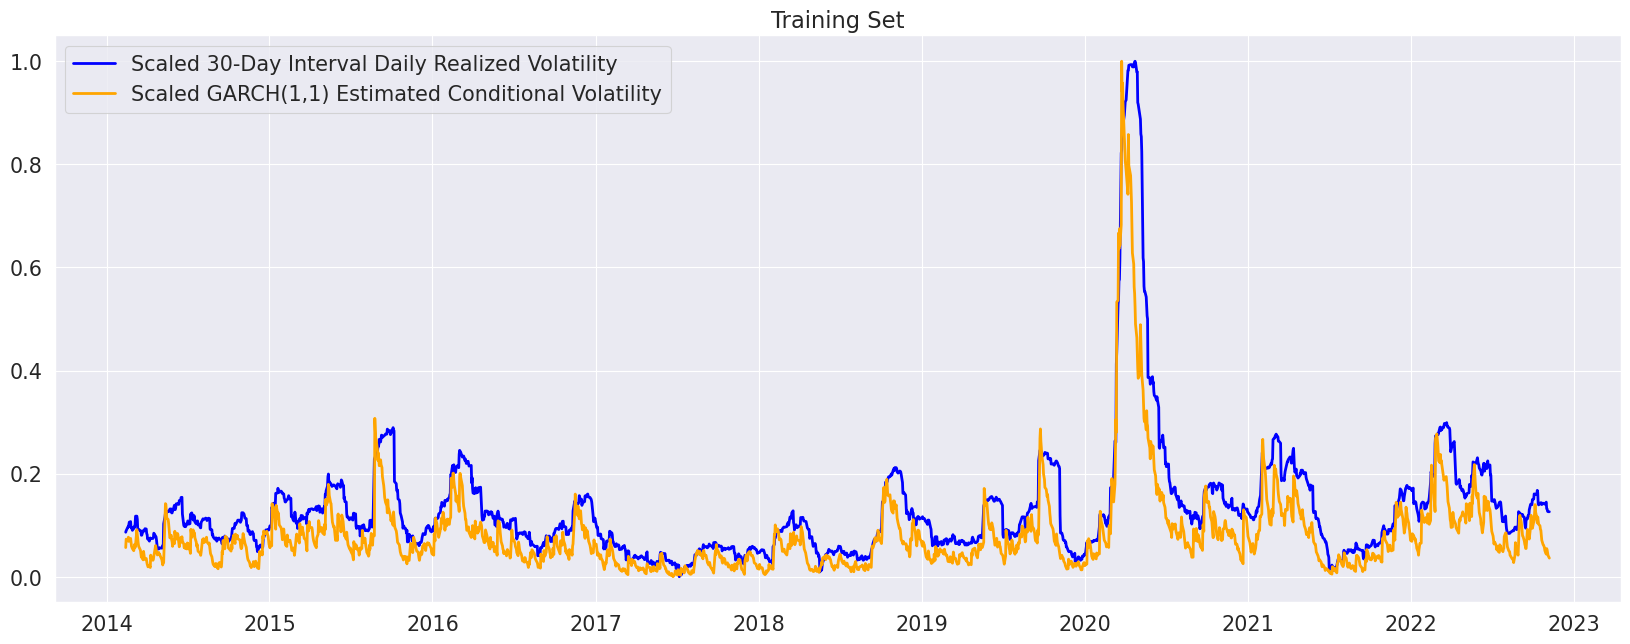

In [71]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')

#### 3.1.1. Analytical-based Forecasting

(Source: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html)

I am implementing rolling one-step forecasting here by refitting the model to ALL the datapoints available up to a certain time step before generating prediction for the next `n_future` days. For example, to make prediction on `vol_future` at time step `t`, I would fit the model to all the `returns` available up to time step `t` and then obtain the average forecasted volatility for a horizon of `n_future = 7`.


The volatility forecasts from the GARCH models using percent returns as input are on a totally different scale compared to the volatilities calculated from log returns. Therefore I am going to normalize the forecasted volatility based on the model's `conditional_volatility` output from the training data, and only comparing the scaled versions of volatilities on the Validation set.

In [72]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [73]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

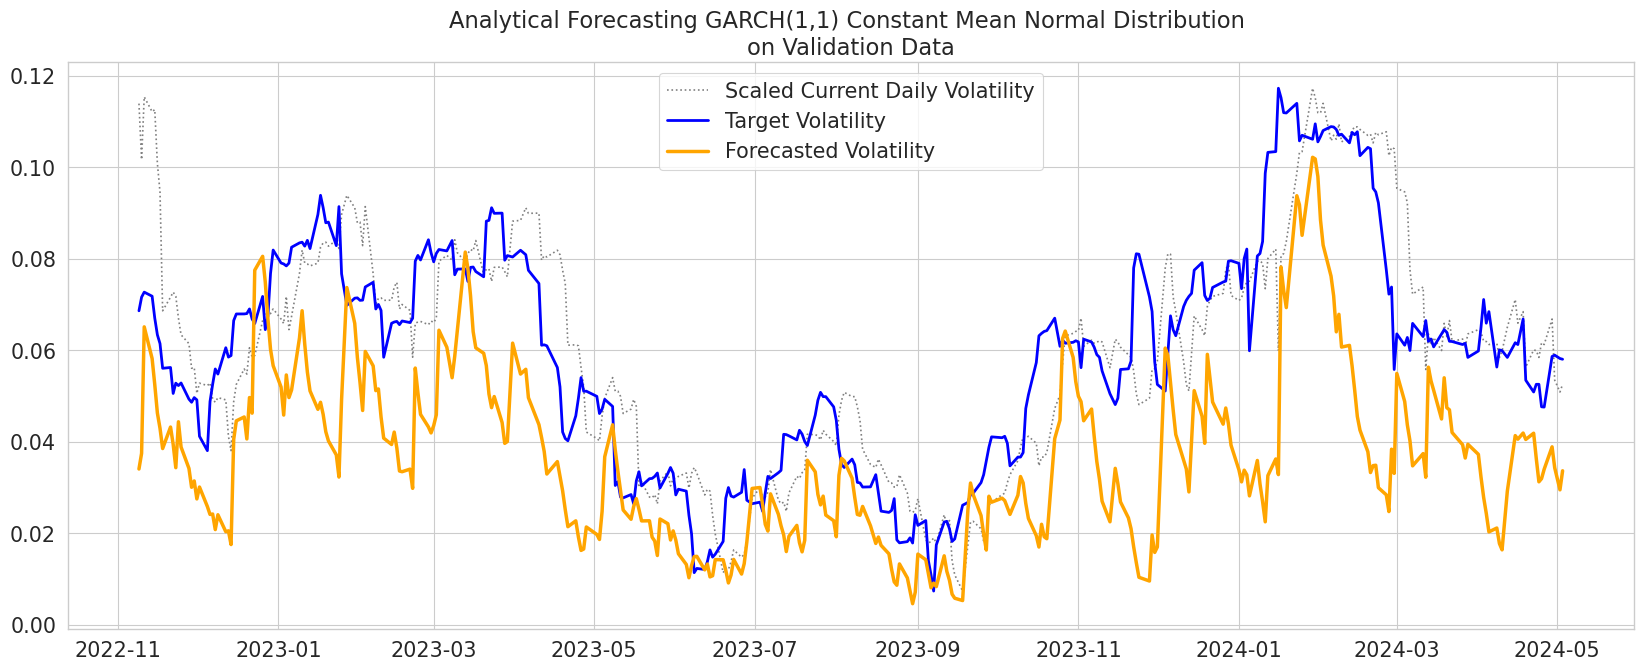

In [74]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled,
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

So 7-day horizon forecasting into the future is still lagging behind compared to target values. Similar to the training volatilities comparison above, GARCH's forecasted volatility appears to be lower side (after normalization).

In [75]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled,
         'GARCH(1,1), Constant Mean, Normal Dist')

Model  Validation RMSPE  Validation RMSE
0                           Mean Baseline          2.642807         0.075018
1  GARCH(1,1), Constant Mean, Normal Dist          0.424654         0.027959

Next, I would inspect the estimated residuals from this first GARCH model.

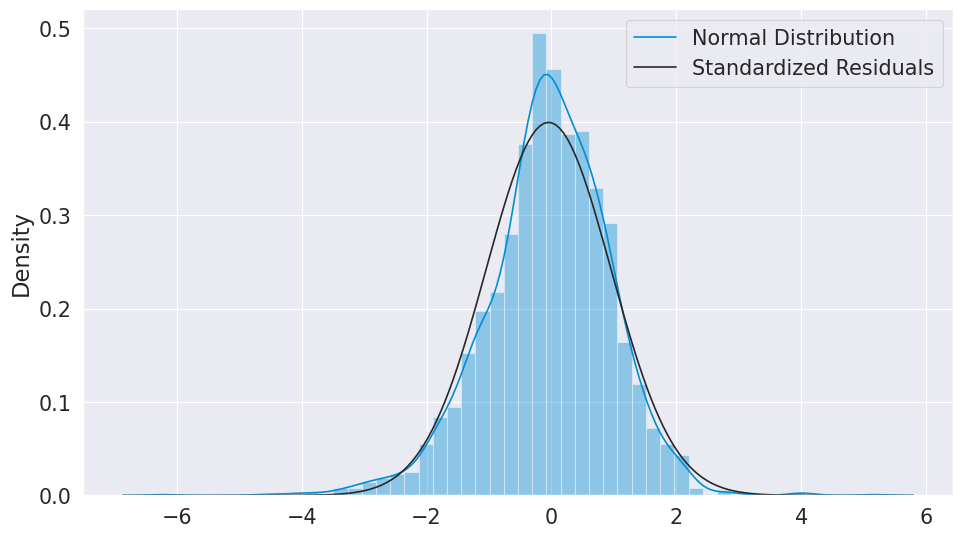

In [76]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show();

(Reference: https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/)

By default, basic GARCH is based on some assumptions that the residuals and the mean return are both normally distributed. However, more often than not, financial time series data does not follow a normal distribution, and it's more likely to observe extreme positive and negative values that are far away from the mean.

Fortunately, there're certain parameters that can be specified in the `arch_model` library to make it more representative of real financial data:
- `'dist'` can be set to `t` for Student's T or `skewt` for skewed Student's T distribution (Student's T distribution is also symmetric and bell-shaped like normal distribution; however it has higher peak and fatter tails allowing more values lying further away from the mean).

Looking at the plot above of the standardized residuals, I think I can try skewed Student's T for the next fit.



## 4. Neural Networks

While GARCH remains the gold standard for volatility prediction within traditional financial institutions, there has been an increasing numbers of professionals and researchers turning to Machine Learning, especially Neural Networks, to gain insights into the financial markets in recent years.

(Reference: **Positional Option Trading** - Euan Sinclair)


In [77]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

For Neural Networks, instead of feeding all available datapoints into the network at once, I will use a **sliding lookback window** to extract uniform input arrays and target outputs. I will just using a stride value of 1 to make sure I get all the inputs and output combinations available since 2500 datapoints is not really a whole lot to spare.

This is a demonstration of sliding window:

In [78]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

In [79]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

To generate predictions using Neural Networks, I will use the same sliding window concept again:


This means that to generate future predictions for a time step `t`, I will need to traverse back in time and collect the last `n_past` datapoints (from time step `t - n_past + 1` to `t` inclusively). That's why the shape of the inputs into these Neural Networks need to be **`[batch_size, n_past, 1]`**.

In [80]:
def forecast(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    i=1
    while(df.vol_current[start_idx:end_idx].shape[0] < 365+n_past-1):
        start_idx = range_idx[0] - timedelta(n_past-1+i)
        i+=1
    mat_X, _ = windowed_dataset(df.vol_current[start_idx:end_idx],
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [81]:
def scale(scaler, y_series):
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [82]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

### 4.2. Univariate Long Short-Term Memory (LSTM)**

(Reference: Geron (2019)

There's a class of Neural Networks called **Recurrent Neural Networks (RNN)** that can "predict the future". RNN works well with time series data, such as stock prices, and can even process sentences, documents, audio samples as inputs. Another application of RNN is in autonomic driving systems, where they're used to anticipate vehicle trajectories and help avoid accidents.

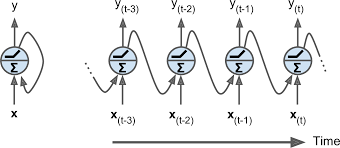

At each time step `t`, the recurrent neuron receives input $x_{t}$ as well as its own output from the previous time step $y_{t-1}$. Since the output of a Recurrent Neuron is a function of all the inputs from the previous time steps, it has a form of *memory* and able to preserve some information through time.

However, due to some transformations that the data goes through when traversing down RNN, some information is lost at each time step, and for a long sequence, the RNN's state contains virtually no information from the first inputs.

**Long Short-Term Memory (LSTM)** was proposed in 1997 by Sepp Hochreiter and Jurgen Schmidhuber. The key part of LSTM is that the network can learn what's important and needs to be stored in the long-term state, and what can be ignored. LSTM looks very similar to a regular RNN cell, but its state is split into 2 vectors:
- $h_{t}$ - for short term state
- $c_{t}$ - for long term state

LSTM is a black box, and can be used like a basic Recurrent Neural Network (RNN) cell. However, it tends to perform much better, helps training converge faster, and also detect long-term dependencies in the data.

LSTM uses an **optimized implementation when running on a GPU**, that's why it's highly recommended to run this second part of the notebook on **Google Colab**.


First, I'm going to use the same lookback window `n_past` as the previous Neural Networks (30), and then depending on the result, I'll try to fine tune that value later.

The first LSTM model would be very simple with only 1 hidden LSTM layer of 20 units. I am using the standard `adam` optimizer here, and would later experiment with other optimizers if needed.

In [83]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1781 (6.96 KB)
Trainable params: 1781 (6.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [84]:
# FIT TO TRAINING DATA
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

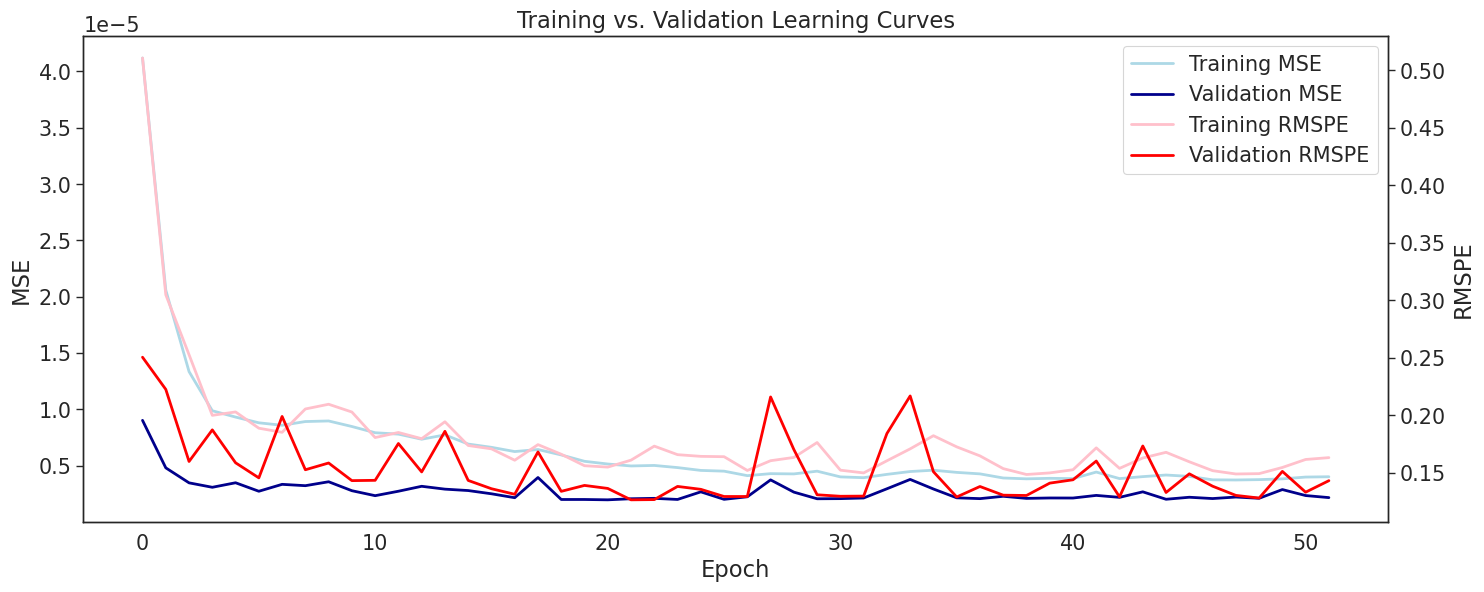

In [85]:
# VISUALIZE TRAINING VS. VALIDATION LOSS METRICS
viz_train_val_metrics(lstm_1_res)

Validation RMSPE is actually lower than Training RMSPE, but overall all the lines except for Training MSE look quite unstable.

In [86]:
# FORECASTING ON VALIDATION SET
lstm_1_preds = forecast(lstm_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)

12/12 [==============================] - 1s 4ms/step


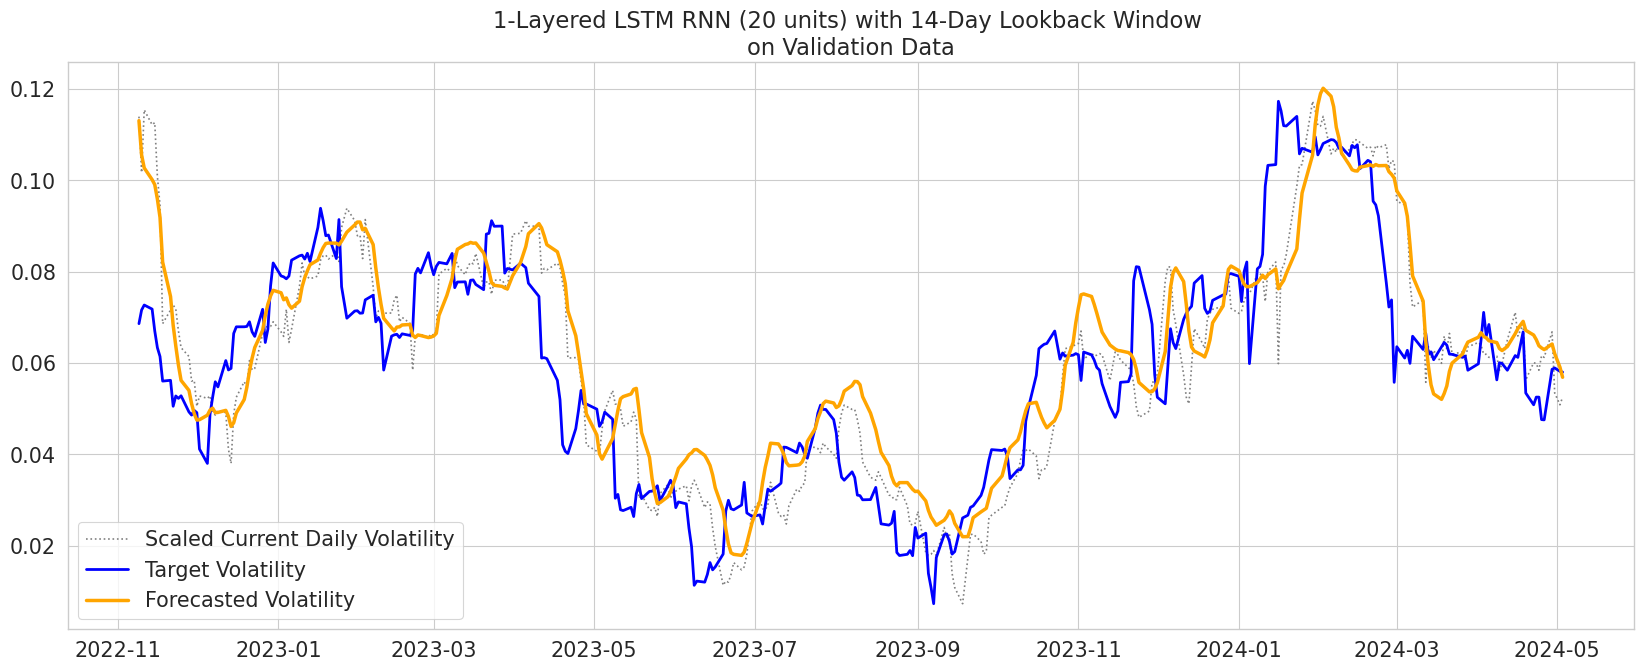

In [87]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_1_preds_scaled,
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")
# plt.savefig(os.path.join(directory_to_img, 'lstm_1.png'),
#             dpi=300, bbox_inches='tight')
plt.show();

Again, predictions traces `vol_current` quite closely, and the prediction line has smoothed out compared to the fully connected NN's predictions (meaning it's less noisy), but it is still also lagging behind compared to desired target.

In [88]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_1_preds_scaled,
         f"LSTM 1 layer 20 units, n_past={n_past}")

Model  Validation RMSPE  Validation RMSE
0                           Mean Baseline          2.642807         0.075018
1  GARCH(1,1), Constant Mean, Normal Dist          0.424654         0.027959
2        LSTM 1 layer 20 units, n_past=14          0.425864         0.014058

Simple 1-layered LSTM is only a tiny bit better than fully connected network on RMSPE, and actually has higher RMSE than the simple LR NN above.

### 4.6. Multivariate LSTM

So far I have only using simple 1-dimensional inputs for all of my models, and for financial data, this is likely insufficient. That could be the reason why most of the above models seems failed to yield better result than Naive Forecasting. It doesn't matter how many neurons or hidden layers are used, or how complex the model's architectures are, inadequate data is most likely not going to produce good results.

For the next section, I'll attempt to create Multivariate Neural Networks to see if additional features could help improve performance.

In [89]:
df.head()

Open         High          Low        Close  \
Date                                                                            
2014-02-13 00:00:00+05:30  6087.549805  6094.399902  5991.100098  6001.100098   
2014-02-14 00:00:00+05:30  6023.750000  6056.399902  5984.600098  6048.350098   
2014-02-18 00:00:00+05:30  6071.299805  6141.700195  6066.799805  6127.100098   
2014-02-19 00:00:00+05:30  6132.049805  6160.350098  6125.750000  6152.750000   
2014-02-20 00:00:00+05:30  6127.149902  6129.100098  6086.450195  6091.450195   

                           Volume   returns  log_returns  vol_current  \
Date                                                                    
2014-02-13 00:00:00+05:30  153700 -1.362589    -0.013720     0.007791   
2014-02-14 00:00:00+05:30  140200  0.787356     0.007843     0.007920   
2014-02-18 00:00:00+05:30  126600  1.302008     0.012936     0.008255   
2014-02-19 00:00:00+05:30   95200  0.418630     0.004178     0.008245   
2014-02-20 00:00:00+05:30  132100 -0.996299    -0.010013     0.008444   

                           vol_future  
Date                                   
2014-02-13 00:00:00+05:30    0.008180  
2014-02-14 00:00:00+05:30    0.008210  
2014-02-18 00:00:00+05:30    0.007951  
2014-02-19 00:00:00+05:30    0.008120  
2014-02-20 00:00:00+05:30    0.008260

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2535 entries, 2014-02-13 00:00:00+05:30 to 2024-06-18 00:00:00+05:30
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         2535 non-null   float64
 1   High         2535 non-null   float64
 2   Low          2535 non-null   float64
 3   Close        2535 non-null   float64
 4   Volume       2535 non-null   int64  
 5   returns      2535 non-null   float64
 6   log_returns  2535 non-null   float64
 7   vol_current  2535 non-null   float64
 8   vol_future   2535 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 262.6 KB


In [91]:
df.describe()

Open          High           Low         Close        Volume  \
count   2535.000000   2535.000000   2535.000000   2535.000000  2.535000e+03   
mean   12437.562998  12495.166194  12358.578667  12428.787757  3.102038e+05   
std     4393.301146   4409.009271   4371.397002   4392.235359  1.963689e+05   
min     6023.750000   6056.399902   5984.600098   6001.100098  0.000000e+00   
25%     8628.899902   8668.574707   8572.899902   8626.825195  1.803500e+05   
50%    10936.700195  10994.900391  10854.849609  10943.599609  2.485000e+05   
75%    16585.349609  16692.575195  16479.700195  16610.074219  3.733000e+05   
max    23570.800781  23579.050781  23499.699219  23557.900391  1.811000e+06   

           returns  log_returns  vol_current   vol_future  
count  2535.000000  2535.000000  2535.000000  2535.000000  
mean      0.058906     0.000534     0.009290     0.009311  
std       1.043626     0.010500     0.005143     0.005153  
min     -12.980466    -0.139038     0.003931     0.003931  
25%      -0.430144    -0.004311     0.006620     0.006620  
50%       0.083556     0.000835     0.008160     0.008163  
75%       0.614629     0.006127     0.010376     0.010401  
max       8.763210     0.084003     0.048656     0.048656

#### 4.6.1. Feature Engineering

The Open/High/Low/Close prices are usually very similar and highly correlated to each other. Therefore, instead of keeping all of them in the dataset, I would add 2 more features:
- **High-Low Spread** - which is the logarithm of the difference between the Highest and Lowest prices intraday as a percentage of the Closing price
- **Open-Close Spread** - which is the difference between the Close and Open prices intraday as a percentage of the Closing price

and then for Volume:
- Volume column has very large values that are billions/millions of times larger than the other features. Therefore I'm going to the get `np.log()` of it, and hopefully transform it into a more normal looking distribution.

and eliminate the three `Close`, `Open`, `High`, `Low` columns.

In [92]:
df_copy=df.copy()

In [93]:
df['HL_sprd'] = np.log((df.High - df.Low) / df.Close)
df['CO_sprd'] = (df.Close - df.Open) / df.Open
df['Volume'] = np.log(df.Volume)

In [94]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the mean of the column
df.fillna(df.mean(), inplace=True)

In [95]:
df.describe()

Open          High           Low         Close       Volume  \
count   2535.000000   2535.000000   2535.000000   2535.000000  2535.000000   
mean   12437.562998  12495.166194  12358.578667  12428.787757    12.493441   
std     4393.301146   4409.009271   4371.397002   4392.235359     0.601819   
min     6023.750000   6056.399902   5984.600098   6001.100098     4.605170   
25%     8628.899902   8668.574707   8572.899902   8626.825195    12.117515   
50%    10936.700195  10994.900391  10854.849609  10943.599609    12.435993   
75%    16585.349609  16692.575195  16479.700195  16610.074219    12.830138   
max    23570.800781  23579.050781  23499.699219  23557.900391    14.409390   

           returns  log_returns  vol_current   vol_future      HL_sprd  \
count  2535.000000  2535.000000  2535.000000  2535.000000  2535.000000   
mean      0.058906     0.000534     0.009290     0.009311    -4.629340   
std       1.043626     0.010500     0.005143     0.005153     0.500833   
min     -12.980466    -0.139038     0.003931     0.003931    -6.007234   
25%      -0.430144    -0.004311     0.006620     0.006620    -4.978589   
50%       0.083556     0.000835     0.008160     0.008163    -4.665096   
75%       0.614629     0.006127     0.010376     0.010401    -4.331086   
max       8.763210     0.084003     0.048656     0.048656    -1.825439   

           CO_sprd  
count  2535.000000  
mean     -0.000703  
std       0.008595  
min      -0.068180  
25%      -0.004838  
50%      -0.000466  
75%       0.003720  
max       0.093065

These numeric features will need to be normalized later since LSTM uses `sigmoid` and `tanh` activation functions, which is very sensitive magnitude.

Since `vol_current` is already derived from `log_returns`, I am not going to include `log_returns` in my model.

In [96]:
features = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current']

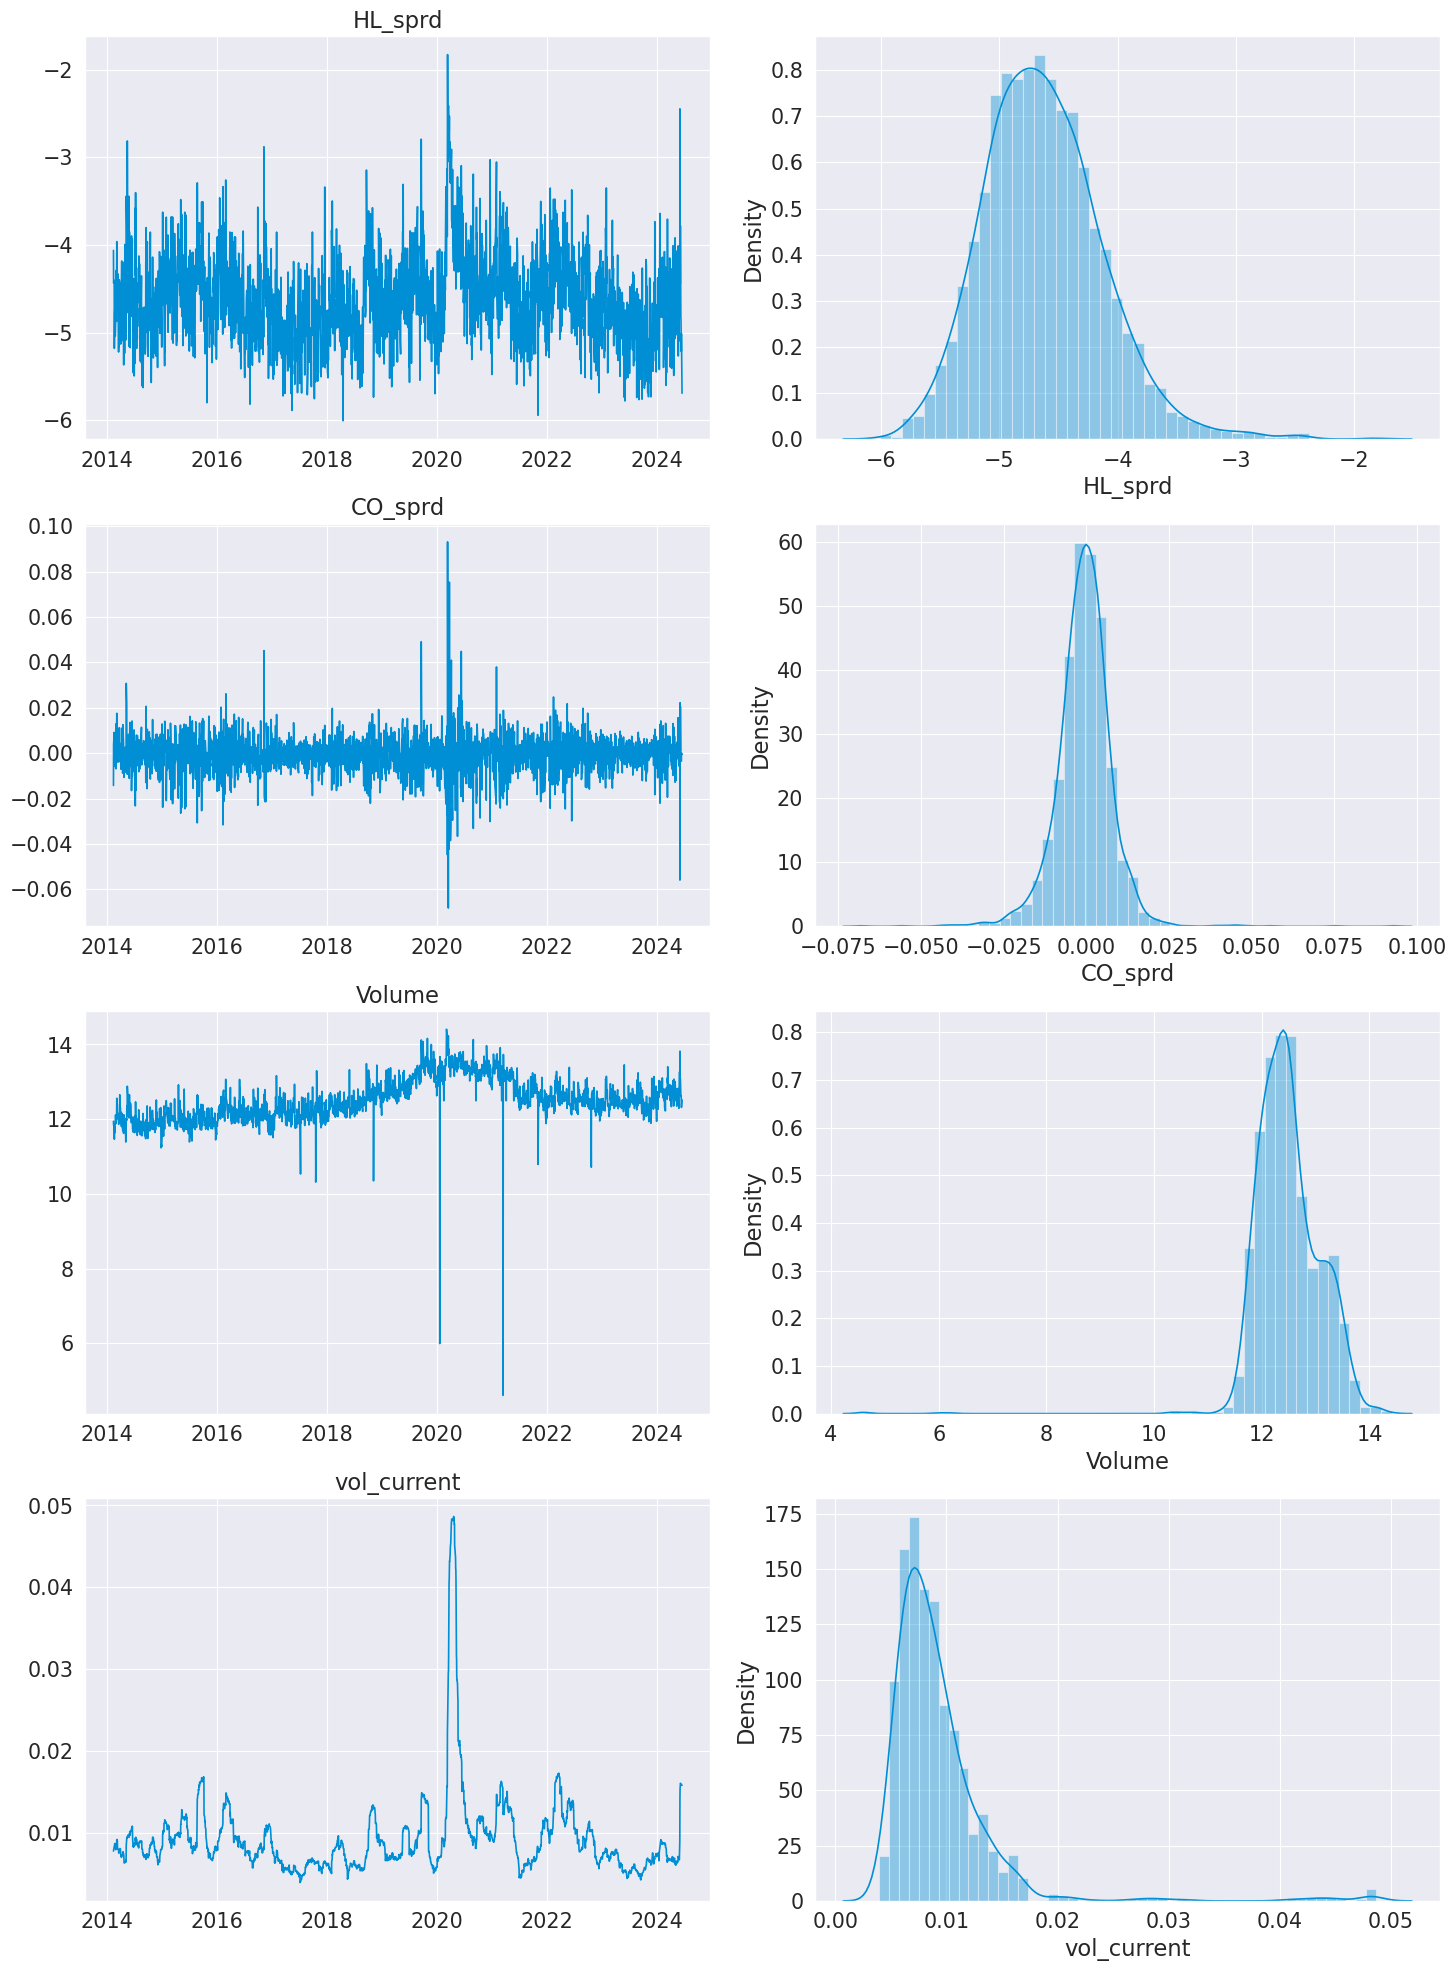

In [97]:
# PLOT EACH NUMERICAL COLUMN
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))

    for i, c in enumerate(features):
        ax1, ax2 = axes[i][0], axes[i][1]
        ax1.plot(df[c])
        ax1.set_title(c)

        sns.distplot(df[c], ax=ax2)

    plt.tight_layout()
    # plt.savefig(os.path.join(directory_to_img, 'features.png'),
    #             dpi=300, bbox_inches='tight')
    plt.show();

#### 4.6.2. Input Reshaping

The predict here would be to predict next 7 days' volatility (`vol_future`) column using 4 input variables:
1. `HL_sprd`
2. `CO_sprd`
3. `Volume`
4. `vol_current`

Reshaping the inputs is the meat of these Multivariate LSTM. Generally speaking, inputs for LSTM should be in the shape of:


**`[batch_size, n_past, input_dims]`**



in which:

- **`batch_size`** is the number of datapoints in each batch
- **`n_past`** is the number of past time steps to be used for prediction (I'll use the same value as above for now).
- **`input_dims`** is the number of input features (which is 4 in this case)  

In [98]:
# SEPARATE INPUT DATAFRAME FROM df
input_df = df[features]

# SEPARATE INPUTS FOR TRAINING SET ONLY
X_train = input_df.loc[train_idx]

In [99]:
X_train.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                                 
2014-02-13 00:00:00+05:30 -4.062063 -0.014201  11.942758     0.007791
2014-02-14 00:00:00+05:30 -4.433659  0.004084  11.850825     0.007920
2014-02-18 00:00:00+05:30 -4.404318  0.009191  11.748788     0.008255
2014-02-19 00:00:00+05:30 -5.180798  0.003376  11.463735     0.008245
2014-02-20 00:00:00+05:30 -4.961616 -0.005826  11.791314     0.008444

In [100]:
input_df.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                                 
2014-02-13 00:00:00+05:30 -4.062063 -0.014201  11.942758     0.007791
2014-02-14 00:00:00+05:30 -4.433659  0.004084  11.850825     0.007920
2014-02-18 00:00:00+05:30 -4.404318  0.009191  11.748788     0.008255
2014-02-19 00:00:00+05:30 -5.180798  0.003376  11.463735     0.008245
2014-02-20 00:00:00+05:30 -4.961616 -0.005826  11.791314     0.008444

In [101]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2140 entries, 2014-02-13 00:00:00+05:30 to 2022-11-07 00:00:00+05:30
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      2140 non-null   float64
 1   CO_sprd      2140 non-null   float64
 2   Volume       2140 non-null   float64
 3   vol_current  2140 non-null   float64
dtypes: float64(4)
memory usage: 83.6 KB


In [102]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2535 entries, 2014-02-13 00:00:00+05:30 to 2024-06-18 00:00:00+05:30
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      2535 non-null   float64
 1   CO_sprd      2535 non-null   float64
 2   Volume       2535 non-null   float64
 3   vol_current  2535 non-null   float64
dtypes: float64(4)
memory usage: 163.6 KB


In [103]:
def forecast_multi(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    i=1
    while(df.vol_current[start_idx:end_idx].shape[0] < 365+n_past-1):
        start_idx = range_idx[0] - timedelta(n_past-1+i)
        i+=1
    mat_X, _ = windowed_dataset(input_df[start_idx:end_idx],
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

### 4.7. Multivariate 2-Layered Bidirectional LSTM with Dropout

My first Multivariate LSTM model would be relatively simple with 2 hidden layers of Bidirectional LSTM (quite similar to the Univariate structure above). However, I will also include Dropout layers in between. Having more features means the model would be more prone to **overfitting**, and Dropout layers can help reduce that.

In [104]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_5 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_5.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_5.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 4)             16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 64)            9472      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [105]:
# FITTING TO TRAINING DATA
lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

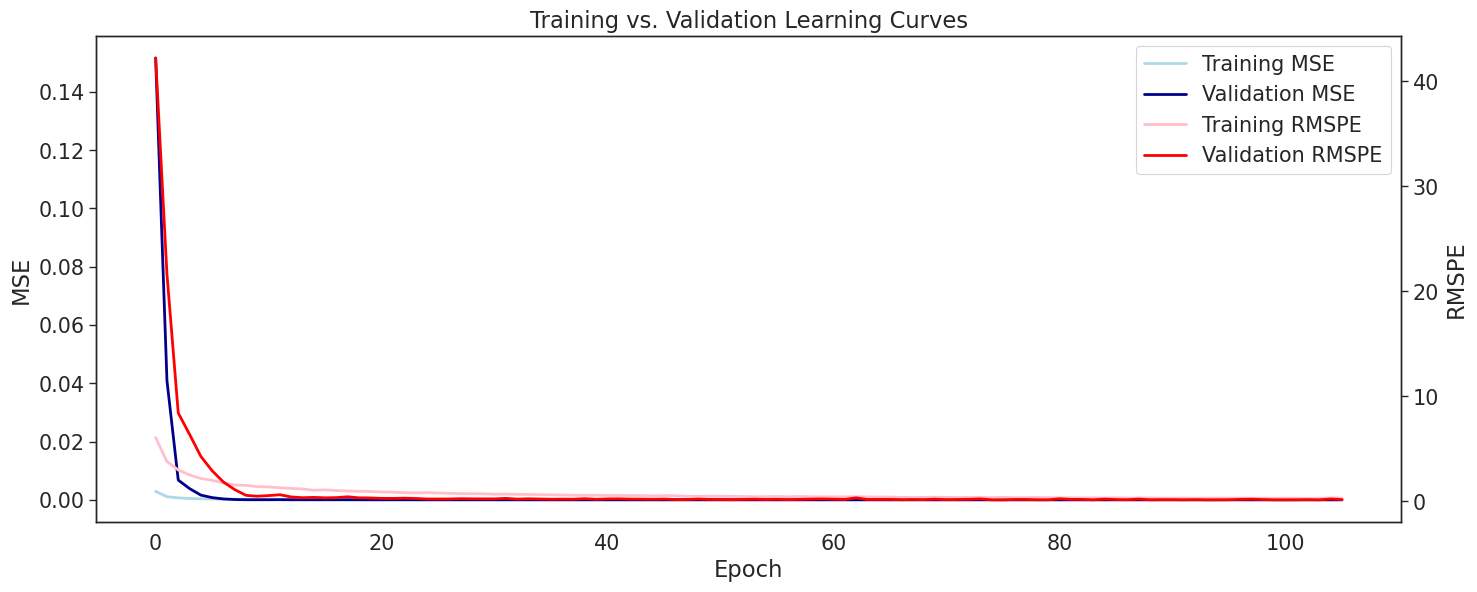

In [106]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_5_res)

In [107]:
# FORECASTING ON VALIDATION SET
lstm_5_preds = forecast_multi(lstm_5, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_5_preds_scaled = scale(scaler_vol, lstm_5_preds)

12/12 [==============================] - 2s 9ms/step


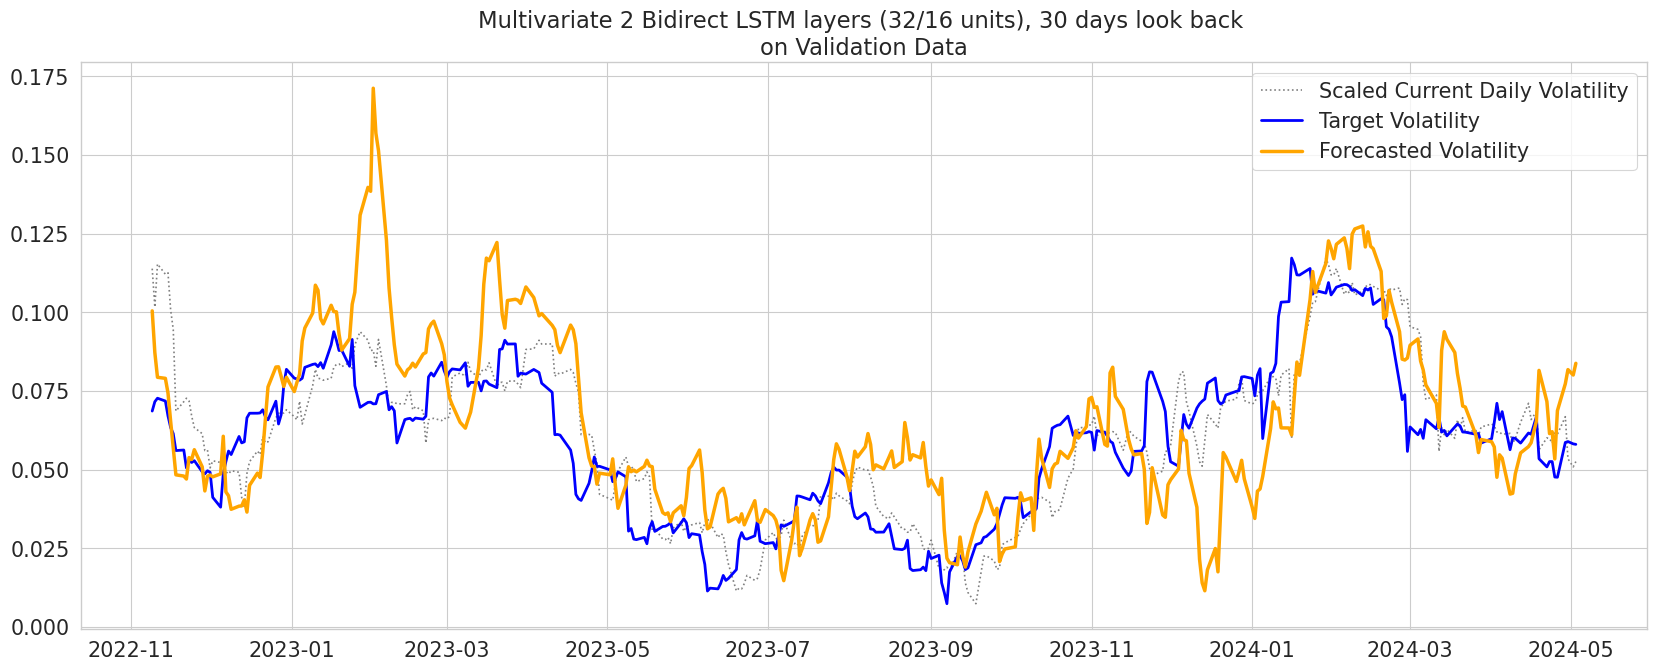

In [108]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_5_preds_scaled,
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back")
# plt.savefig(os.path.join(directory_to_img, 'lstm_5.png'),
#             dpi=300, bbox_inch='tight')
plt.show();

In [109]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_5_preds_scaled,
         f"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past={n_past}")

Model  \
0                                                 Mean Baseline   
1                        GARCH(1,1), Constant Mean, Normal Dist   
2                              LSTM 1 layer 20 units, n_past=14   
3  Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30   

   Validation RMSPE  Validation RMSE  
0          2.642807         0.075018  
1          0.424654         0.027959  
2          0.425864         0.014058  
3          0.559334         0.022464

### 4.8. Multivariate 3-Layered Bidirectional LSTM

Next, I'm going to add more LSTM layers to see if that helps improve performance.

In [110]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_6 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # normalize,
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_6.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_6.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_6.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 4)             16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 128)           35328     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 30, 64)            41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                        

In [111]:
lstm_6_res = lstm_6.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

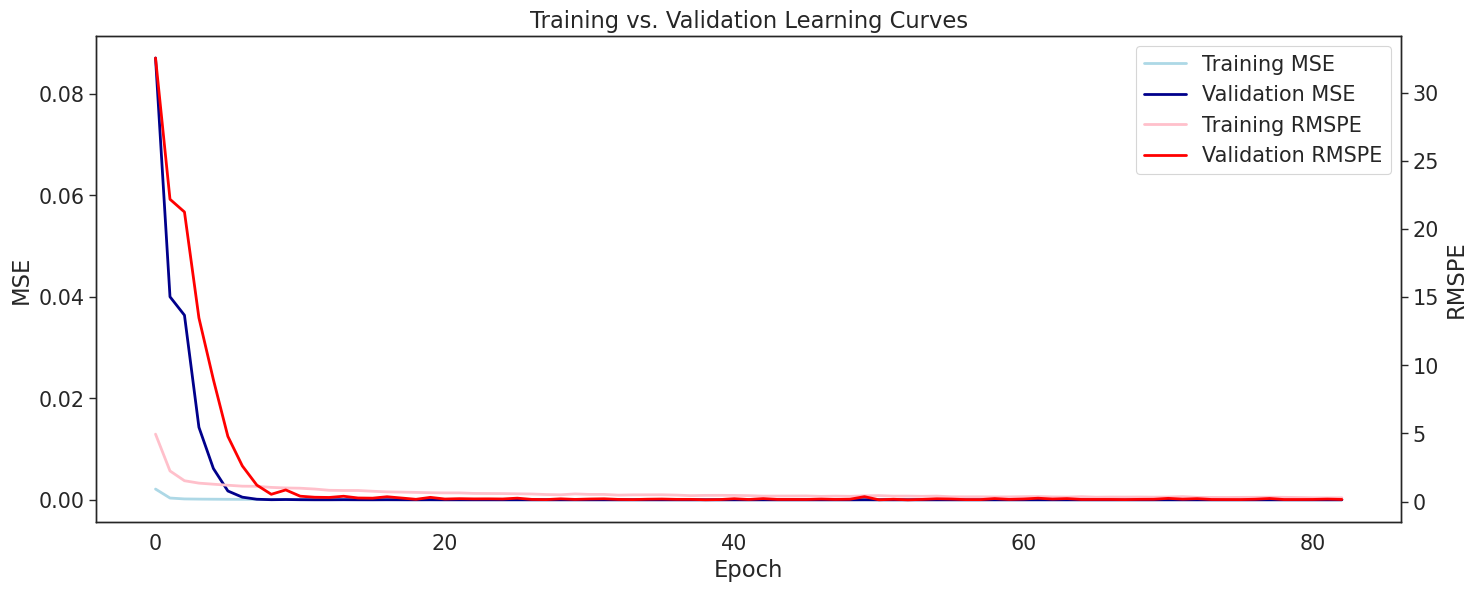

In [112]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_6_res)

In [113]:
# FORECASTING ON VALIDATION SET
lstm_6_preds = forecast_multi(lstm_6, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_6_preds_scaled = scale(scaler_vol, lstm_6_preds)

12/12 [==============================] - 3s 19ms/step


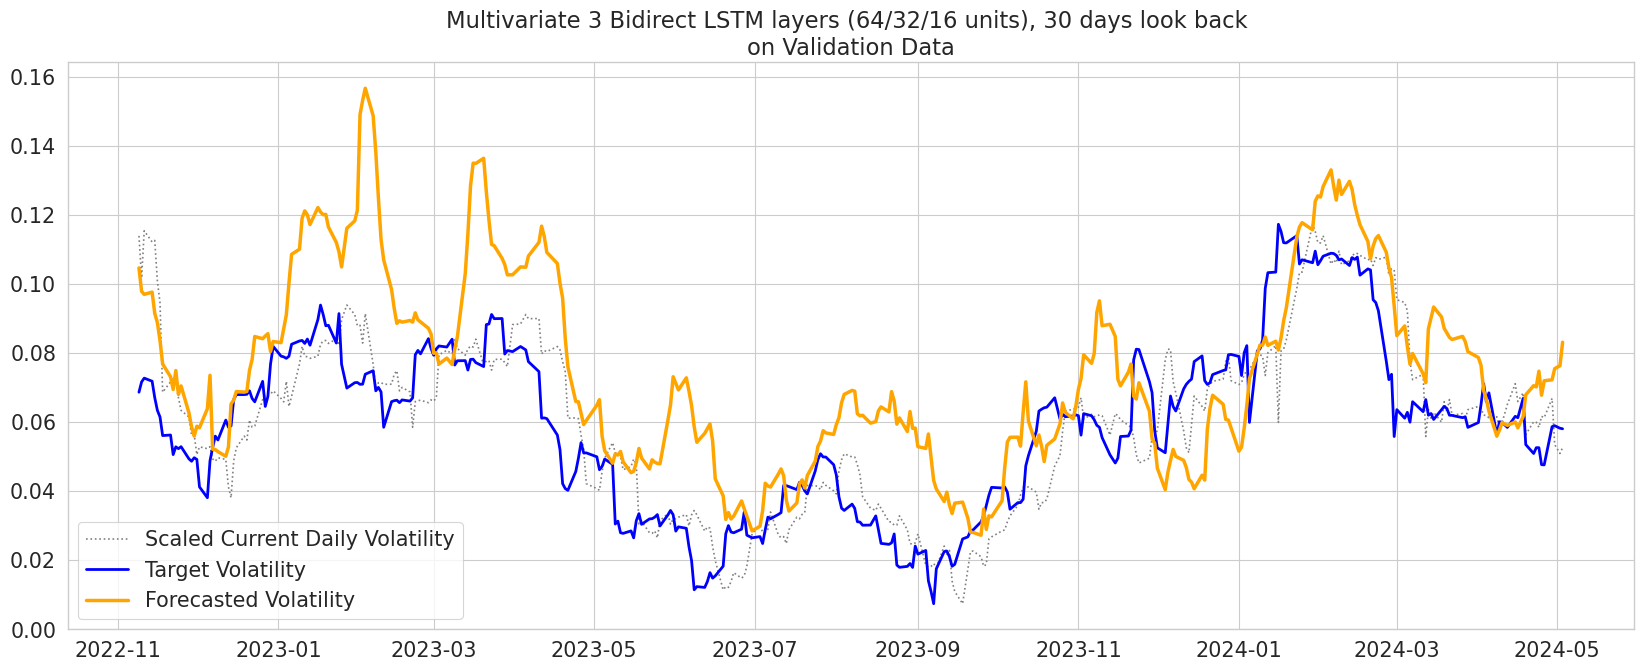

In [114]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_6_preds_scaled,
          f"Multivariate 3 Bidirect LSTM layers (64/32/16 units), {n_past} days look back")

plt.show();

In [115]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_6_preds_scaled,
         f"Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past={n_past}")

Model  \
0                                                    Mean Baseline   
1                           GARCH(1,1), Constant Mean, Normal Dist   
2                                 LSTM 1 layer 20 units, n_past=14   
3     Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30   
4  Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past=30   

   Validation RMSPE  Validation RMSE  
0          2.642807         0.075018  
1          0.424654         0.027959  
2          0.425864         0.014058  
3          0.559334         0.022464  
4          0.807804         0.025428

## **Final Model**

In [116]:
perf_df.sort_values(by='Validation RMSPE', ascending=True)

Model  \
1                           GARCH(1,1), Constant Mean, Normal Dist   
2                                 LSTM 1 layer 20 units, n_past=14   
3     Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30   
4  Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past=30   
0                                                    Mean Baseline   

   Validation RMSPE  Validation RMSE  
1          0.424654         0.027959  
2          0.425864         0.014058  
3          0.559334         0.022464  
4          0.807804         0.025428  
0          2.642807         0.075018

For this final model, I'll re-create the same architecture as model #12 (Multivariate Bidirectional LSTM with 2 layers of 32/16 units) and a lookback window `n_past = 30` and `batch_size = 64`. However, I'll extend the training to include the validation set as well. This is important in time series data since the more recent time steps would most likely carry more relevant information for successful forecasting than data from a year ago.

Since the validation MSE and RMSPE lines have been very unstable, I will extend the training epochs to 500 to seee if that could help capture better weights.

In [ ]:
# CREATE DATASET THAT COMBINES BOTH TRAINING & VALIDATION
tv_df = input_df[:split_time_2]
tv_y = df.vol_future[:split_time_2]

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_tv, mat_y_tv = windowed_dataset(tv_df, tv_y, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_final = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_final.compile(loss='mse',
                    optimizer="adam",
                    metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_final.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_final.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 30, 4)             16        
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 64)            9472      
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 19,889
Trainable params: 19,881
Non-trainable params: 8
____________________________________________________

In [ ]:
lstm_final_res = lstm_final.fit(mat_X_tv, mat_y_tv, epochs=500,
                                validation_split=0.2,
                                callbacks=[checkpoint_cb, early_stopping_cb],
                                verbose=0, batch_size=batch_size, shuffle=True)

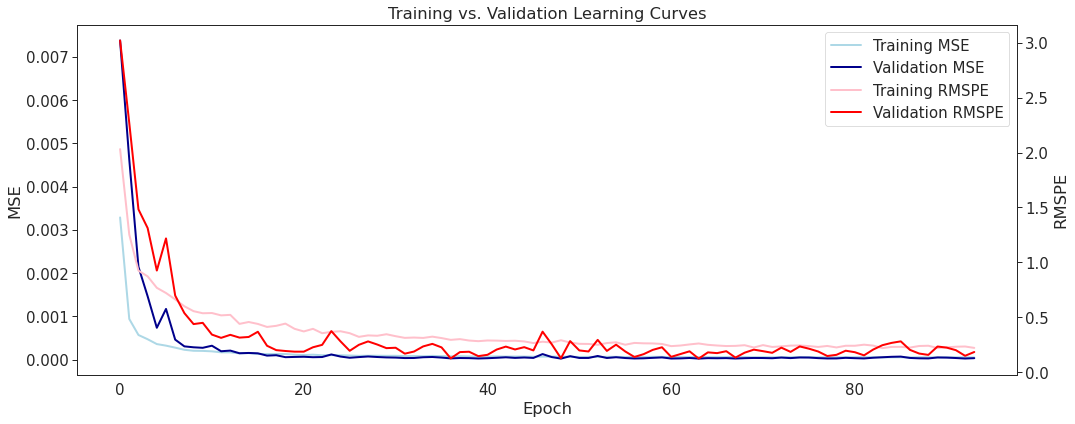

In [ ]:
viz_train_val_metrics(lstm_final_res)

### Final Model's Predictions on Test Set

In [ ]:
# FORECASTING ON VALIDATION SET
y_test_preds = forecast_multi(lstm_final, test_idx)

In [ ]:
y_test_preds.describe()

count    30.000000
mean      0.035082
std       0.001571
min       0.032232
25%       0.033878
50%       0.035131
75%       0.036093
max       0.038537
dtype: float64

In [ ]:
y_test.describe()

count    30.000000
mean      0.034526
std       0.001731
min       0.031663
25%       0.033294
50%       0.034424
75%       0.035844
max       0.037194
Name: vol_future, dtype: float64

In [ ]:
# GETTING DAILY VOLATILITY QUANTILES
q1 = df.vol_current[:split_time_2].describe()['25%']

q2 = df.vol_current[:split_time_2].describe()['50%']

q3 = df.vol_current[:split_time_2].describe()['75%']

In [ ]:
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

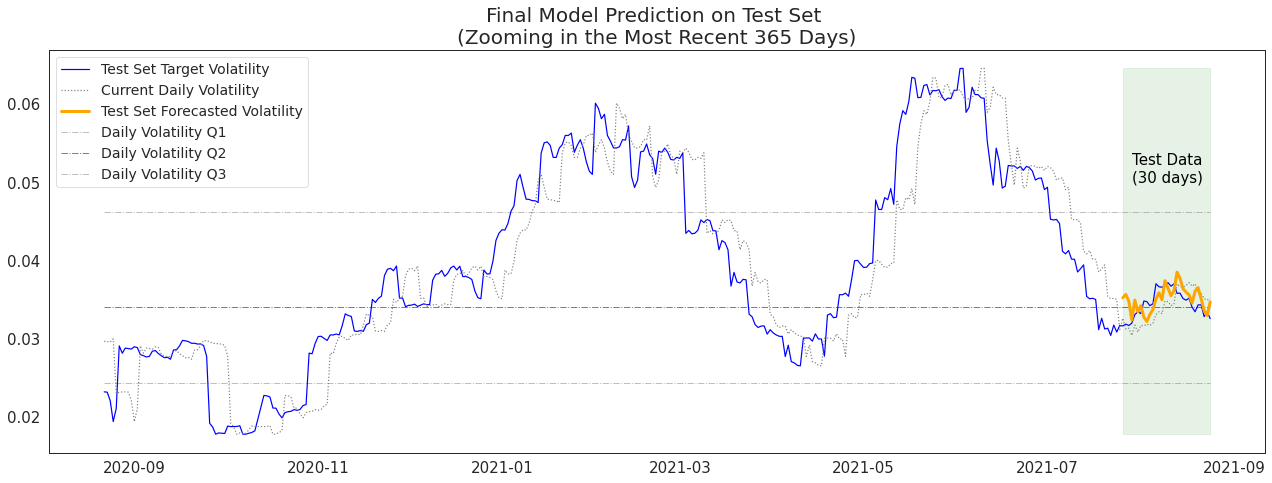

In [ ]:
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib

# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue',
                label=f"Test Set Target Volatility")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls=':',
                label=f"Current Daily Volatility")
    ax1.plot(y_test_preds, color='orange', lw=3,
                label=f'Test Set Forecasted Volatility')

    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q, color=q_colors[i], alpha=0.5, label=f'Daily Volatility Q{i+1}', ls='-.', lw=1,
                    xmin=df.vol_future[-n_display:].index[0],
                    xmax=df.vol_future[-n_display:].index[-1])

    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA
    w = len(test_idx) - 1
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05,
             'Test Data\n(30 days)',
             fontsize=15, color='black')

    plt.title(f'Final Model Prediction on Test Set \n(Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'final_lstm_test_preds.png'),
                dpi=300, bbox_inches='tight')
    plt.show();

In [ ]:
# GENERATING PREDICTIONS ON THE WHOLE DATASET (7 years)
mat_X_all, _ = windowed_dataset(input_df, df.vol_future, n_past)
preds_all = pd.Series(lstm_final.predict(mat_X_all)[:,0],
                      index=df.index[-(mat_X_all).shape[0]:])

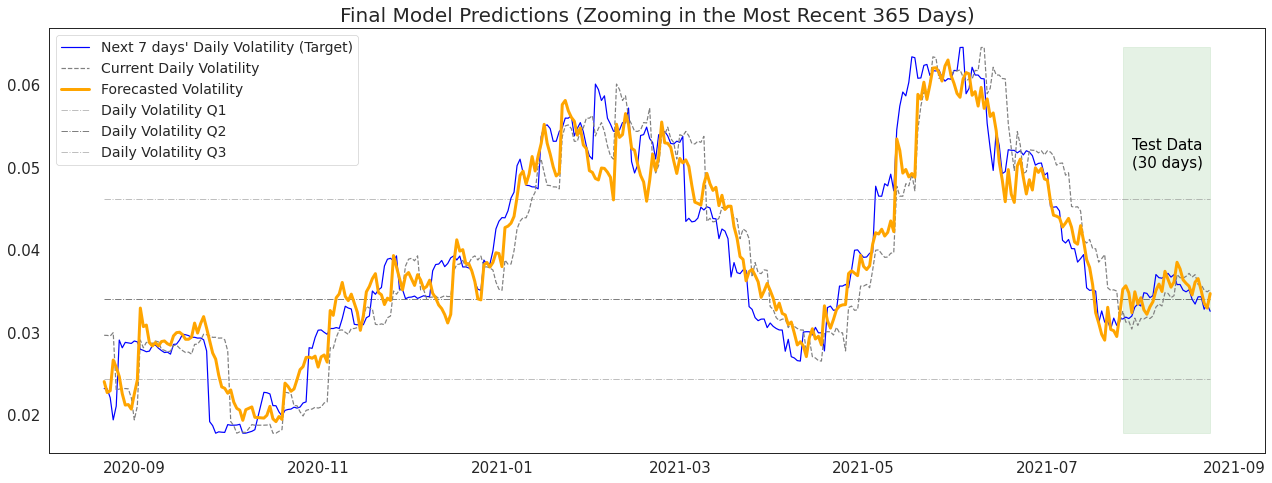

In [ ]:
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue',
                label=f"Next {n_future} days' Daily Volatility (Target)")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls='--',
                label=f"Current Daily Volatility")
    ax1.plot(preds_all[-n_display:], color='orange', lw=3,
                label=f'Forecasted Volatility')

    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q,
                   xmin=df.vol_future[-n_display:].index[0],
                   xmax=df.vol_future[-n_display:].index[-1],
                   label=f'Daily Volatility Q{i+1}',
                   ls='-.', lw=1, color=q_colors[i], alpha=0.5)

    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA
    w = len(test_idx) - 1
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05,
             'Test Data\n(30 days)',
             fontsize=15, color='black')

    plt.title(f'Final Model Predictions (Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'final_lstm_preds.png'),
                dpi=300, bbox_inches='tight')
    plt.show();

It should be stressed that the model was trained on both the training and validation data this time. Therefore it'd naturally trace the target more closely up until the third week of July 2021 where the validation ends.

In [ ]:
perf_df.to_pickle("performance_df.pkl")

In [ ]:
print('RMSPE on Test Set:', RMSPE(y_test, y_test_preds))

RMSPE on Test Set: 0.053450330401007703


In [ ]:
1-RMSPE(y_test, y_test_preds)

0.9465496695989923

# References:

1. Géron, A. (2019). *In Hands-on machine learning with Scikit-Learn & TensorFlow: concepts, tools, and techniques to build intelligent systems.* O'Reilly Media, Inc.

2. Sinclair, E. (2020). *Positional option trading: An advanced guide.* John Wiley &amp; Sons.

3. https://algotrading101.com/learn/yfinance-guide/

4. https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

5. https://insights.deribit.com/options-course/

6. https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html

7. https://www.investopedia.com/terms/v/vix.asp

8. https://www.hindawi.com/journals/complexity/2021/6647534/

9. https://github.com/ritvikmath/Time-Series-Analysis/blob/master/GARCH%20Stock%20Modeling.ipynb

10. https://github.com/ritvikmath/Time-Series-Analysis/blob/master/GARCH%20Model.ipynb

11. https://www.kaggle.com/c/optiver-realized-volatility-prediction

12. https://www.youtube.com/watch?v=NKHQiN-08S8

13. https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/

14. https://towardsdatascience.com/time-series-analysis-on-multivariate-data-in-tensorflow-2f0591088502

15. https://deepmind.com/blog/article/wavenet-generative-model-raw-audio

16. https://github.com/philipperemy/keras-tcn

17. http://users.metu.edu.tr/ozancan/ARCHGARCHTutorial.html

18. https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95

19. https://github.com/chibui191/bitcoin_volatility_forecasting.git